<a href="https://colab.research.google.com/github/Jeff-AB/ECE542FinalProject/blob/jeff-development/ECE542FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECE 542 Final Project
## Real Time Results
[Link to Video](https://youtu.be/UldWBmV3VfU)
## Model Summary

<img src=https://ronjian.github.io/assets/Mask-RCNN/mask-rcnn.png width="500">

# References

# Mask R CNN
1. https://www.analyticsvidhya.com/blog/2019/07/computer-vision-implementing-mask-r-cnn-image-segmentation/

2. https://machinelearningmastery.com/how-to-perform-object-detection-in-photographs-with-mask-r-cnn-in-keras/

3. https://engineering.matterport.com/splash-of-color-instance-segmentation-with-mask-r-cnn-and-tensorflow-7c761e238b46 (Best)

In [0]:
!pip install tf-nightly-gpu

     |████████████████████████████████| 519.6MB 17kB/s 
     |████████████████████████████████| 3.0MB 32.5MB/s 
     |████████████████████████████████| 460kB 42.8MB/s 


In [0]:
%tensorflow_version 1.x
import tensorflow
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

# Google Colab or Local Notebook Settings
colab_notebook = True

data_dir = None
aug_data_dir = None

# Assign path variables
if colab_notebook:
    #Mount Google Drive Folder
    from google.colab import drive
    
    mount_dir = '/content/drive'
    drive.mount(mount_dir)
    
    data_dir = '/content/drive/My Drive/ECE 542 Final Project/gtFine'

    train_dir = '/content/drive/My Drive/ECE 542 Final Project/gtFine/train'
    val_dir = '/content/drive/My Drive/ECE 542 Final Project/gtFine/val'

    CITI_ROOT = os.path.abspath('/content/drive/My Drive/ECE 542 Final Project/cityscapesScripts/')
    MASK_ROOT = os.path.abspath('/content/drive/My Drive/ECE 542 Final Project/Mask_RCNN/')


    sys.path.append(MASK_ROOT)
    sys.path.append(CITI_ROOT)
    

TensorFlow 1.x selected.
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#!sudo mount -t tmpfs -o size=13G tempfs "/content/drive/My Drive/ECE 542 Final Project/cityscapes-data"
#!sudo ls /etc/fstab

# Model Setup

Run this cell in order to setup the file structure that Mask R-CNN will expect to use. This includes MODEL_DIR for saving models, 

*   `MODEL_DIR`: directory to write trained models to
*   `COCO_MODEL_PATH`: directory to read trained models in from
*   `IMAGE_DIR`: directory root for image data (training and testing)


In [0]:
# Root directory of the project
ROOT_DIR = os.path.abspath('/content/drive/My Drive/ECE 542 Final Project/Mask_RCNN/')

print(ROOT_DIR)

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, 'samples/coco/'))  # To find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, 'logs')

# Local path to trained weights file
LATEST_MODEL_PATH = os.path.join(ROOT_DIR, 'logs', 'cityscape20200424T0036', 'mask_rcnn_cityscape_0006.h5')
# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, 'mask_rcnn_coco.h5')
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.abspath('/content/drive/My Drive/ECE 542 Final Project/cityscapes-data/leftImg8bit_trainvaltest/leftImg8bit')

/content/drive/My Drive/ECE 542 Final Project/Mask_RCNN


Using TensorFlow backend.


# Dataset organization

We read in data using the following structure. This will allow us to have annotations stored in a JSON format in one directory with images stored in another with train and val subset labels respectively. 

```
DATA_DIR
│
└───annotations
│   │   bdd100k_labels_images_<subset><year>.json
│   
└───<subset><year>
    │   image021.jpeg
    │   image022.jpeg
```



In [0]:
from mrcnn.config import Config

GPU_COUNT = 1
IMAGES_PER_GPU = 2
LEARNING_RATE = 0.0001
NAME = 'cityscape'
NUM_CLASSES = 35 #1+34 # Background (inherited from utils.Dataset) + FG classes (listed below)
WEIGHT_DECAY = 0.0001

class TrainingConfig(Config):
    # TO-OPT: Set batch size to 20 by default.
    GPU_COUNT = GPU_COUNT
    IMAGES_PER_GPU = IMAGES_PER_GPU
    LEARNING_RATE = LEARNING_RATE
    NAME = NAME
    NUM_CLASSES = NUM_CLASSES
    WEIGHT_DECAY = WEIGHT_DECAY
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

config = TrainingConfig()
config.display()

class_names = ['ego vehicle', 'rectification border', 'out of roi', 'static', 'dynamic', 'ground', 'road', 'sidewalk', 'parking', 'rail track', 'building', 'wall', 'fence',
               'guard rail', 'bridge', 'tunnel', 'pole', 'polegroup', 'traffic light', 'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus', 'caravan',
               'trailer', 'train', 'motorcycle', 'bicycle', 'license plate']


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                47
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.0001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE            

In [0]:
import numpy as np
import json
import cv2
import matplotlib.pyplot as plt
import PIL.ImageDraw as ImageDraw
import PIL.Image as Image
import os
import random

from tqdm import tqdm    
from mrcnn.utils import Dataset
from cityscapesscripts.helpers.csHelpers import getCoreImageFileName

class CityscapesSegmentationDataset(Dataset):
    
    def load_cityscapes(self, root_directory, subset):

        # add class names
        class_names = ['ego vehicle', 'rectification border', 'out of roi', 'static', 'dynamic', 'ground', 'road', 'sidewalk', 'parking', 'rail track', 'building', 'wall', 'fence',
               'guard rail', 'bridge', 'tunnel', 'pole', 'polegroup', 'traffic light', 'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus', 'caravan',
               'trailer', 'train', 'motorcycle', 'bicycle', 'license plate']
        
        for i, name in enumerate(class_names[:-1]):
            self.add_class('cityscape', i, name)
        
        # license plate has id as -1
        self.add_class('cityscape',-1,class_names[-1])

        # Write out locations for annotations and images
        # self.data_dir: location for json annotations
        # image_dir: location for image path assignment
        if subset == 'train':
            self.data_dir = os.path.join(root_directory, 'train')
            image_dir = os.path.join(IMAGE_DIR, 'train')
        elif subset == 'val':
            self.data_dir = os.path.join(root_directory, 'val')
            image_dir = os.path.join(IMAGE_DIR, 'val')
        elif subset == 'test':
            self.data_dir = os.path.join(root_directory, 'test')
            image_dir = os.path.join(IMAGE_DIR, 'test')
        else:
            raise Exception('No valid subset provided')

        # Create set to prevent redundant image_id's (string, partial file name)
        image_id_set = set()
        for root, dirs, filenames in os.walk(self.data_dir):
          for filename in filenames:
              image_id = getCoreImageFileName(filename)
              image_id_set.add(image_id)
        
        # Add unique image id's to dataset
        for image_id in image_id_set:
          city = image_id.split('_')[0] # First element in list should be city
          path = os.path.join(image_dir, city, image_id + '_leftImg8bit.png')
          self.add_image(source = "cityscape", 
          image_id=image_id,
          path=path)
            
        #print('---------------')
        #print(self._image_ids)
        #print('---------------')
        #print(len(self._image_ids))
        # return self._image_ids
        #image_id = random.choice(self._image_ids)
        #print("Sample image: %s" % image_id)

    def load_mask(self, image_id):
        '''
        Loads mask corresponding to an image id
        
        image_id: the unique id of the form city_sequenceNb_frame_Nb
        
        returns a bool array of masks and a list of class ids
        The polygons are extracted from the json files and constructed into a binary image
        using PIL. 
        '''
        
        # Retrieve available image metadata from dataset
        image_info = self.image_info[image_id]
        image_name = image_info['id']

        # Fetch and process the required metadata for the mask 
        city = image_name.split('_')[0] # First element in list should be city
        annotation_path = os.path.join(os.path.join(self.data_dir, city), image_name + '_gtFine_polygons.json')
        ann_dict = {}
        
        with open(annotation_path) as annotation:
            ann_dict = json.load(annotation)
        masks = []
        class_ids = []
        
        for obj in tqdm(ann_dict['objects']):
            # Must search list of dictionaries to find class_id (int) assosciated with class_name (string)
            class_name = obj['label']
            if class_name.endswith('group'):  # Some classes can be grouped if no clear boundary can be seen
              class_name = class_name[:-5]    # Remove group from the class name and continue as if one object
              #print('\nGroup removed from class %s\n' % class_name)
              
            #class_dict = next(item for item in self.class_info if item["name"] == class_name)
            class_dict = list(filter(lambda class_info_item: class_info_item['name'] == class_name, self.class_info))
            if (len(class_dict) == 0):
              print('Class %s not handled by current software\n' % class_name)
            else:
              class_ids.append(class_dict[0]['id'])

            # Generate bitmask skeleton for polygon drawing
            mask = Image.new(mode = '1', size = (ann_dict['imgWidth'], ann_dict['imgHeight']))
            draw = ImageDraw.Draw(mask)
            
            # Retrieve bitmask polygon info from JSON
            try:
                points = obj['polygon']
            except:
                print('no polygons for {}'.format(obj['label']))
            
            # PIL expects a tuple of tuples for points
            points = [tuple(coords) for coords in points]
            points = tuple(points)
            
            # Draw bitmask polygon from points
            draw.polygon((points), fill=1)
            masks.append(mask)

        if (class_ids):
          # Stack masks and class_ids
          masks = np.stack(masks, axis=2).astype(np.bool)
          class_ids = np.array(class_ids, dtype=np.int32)
          return masks, class_ids
        else:
          # Return empty mask
          return super(CityscapesSegmentationDataset, self).load_mask(image_id)

In [0]:
# csds = CityscapesSegmentationDataset()
# csds.load_cityscapes(data_dir, 'val')
# masks, class_ids = csds.load_mask('frankfurt_000000_000294')
# num_instances = len(class_ids)
# select = random.randint(0,num_instances - 1)

# print(class_ids[select])
# fig=plt.figure(figsize=(9, 8), dpi= 80, facecolor='w', edgecolor='k')
# plt.imshow(np.asarray(masks[select]), cmap=plt.cm.gray)

In [0]:
#Training dataset.
dataset_train = CityscapesSegmentationDataset()
dataset_train.load_cityscapes(data_dir, 'train')
dataset_train.prepare()


# Validation dataset

dataset_val = CityscapesSegmentationDataset()
dataset_val.load_cityscapes(data_dir, 'val')
dataset_val.prepare()


In [0]:
print(len(dataset_train.image_ids))
print(dataset_train.class_info)

2975
[{'source': '', 'id': 0, 'name': 'BG'}, {'source': 'cityscape', 'id': 0, 'name': 'ego vehicle'}, {'source': 'cityscape', 'id': 1, 'name': 'rectification border'}, {'source': 'cityscape', 'id': 2, 'name': 'out of roi'}, {'source': 'cityscape', 'id': 3, 'name': 'static'}, {'source': 'cityscape', 'id': 4, 'name': 'dynamic'}, {'source': 'cityscape', 'id': 5, 'name': 'ground'}, {'source': 'cityscape', 'id': 6, 'name': 'road'}, {'source': 'cityscape', 'id': 7, 'name': 'sidewalk'}, {'source': 'cityscape', 'id': 8, 'name': 'parking'}, {'source': 'cityscape', 'id': 9, 'name': 'rail track'}, {'source': 'cityscape', 'id': 10, 'name': 'building'}, {'source': 'cityscape', 'id': 11, 'name': 'wall'}, {'source': 'cityscape', 'id': 12, 'name': 'fence'}, {'source': 'cityscape', 'id': 13, 'name': 'guard rail'}, {'source': 'cityscape', 'id': 14, 'name': 'bridge'}, {'source': 'cityscape', 'id': 15, 'name': 'tunnel'}, {'source': 'cityscape', 'id': 16, 'name': 'pole'}, {'source': 'cityscape', 'id': 17, 

In [0]:
print("Image IDs: {}".format(dataset_train.image_ids))
print("Image Count: {}".format(len(dataset_train._image_ids)))
print("Class Count: {}".format(dataset_train.num_classes))

Image IDs: [   0    1    2 ... 2972 2973 2974]
Image Count: 2975
Class Count: 35


In [0]:
# Create model object in training mode.
model = modellib.MaskRCNN(mode="training", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO, excepting areas for training
# We can exclude the bounding box layers for now, but they will
# be useful for interpreting our images for now

#model.load_weights(COCO_MODEL_PATH, by_name=True, exclude=["mrcnn_bbox_fc",
#                                                           "mrcnn_bbox",
#                                                           "mrcnn_mask",
#                                                           "mrcnn_class_logits"])
model.load_weights(LATEST_MODEL_PATH, by_name=True)

Re-starting from epoch 6


In [0]:
import keras
keras.__version__

'2.3.1'

# Model Training

Run these cells in order to train the Mask R-CNN model's mask and ROI-related layers (excludes CNN backbone layers). 

In [0]:
augmentation = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips (fine since we're on a road)
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images. Good for poorly resolved
    # moving images
    iaa.Sometimes(
        0.25,
        iaa.GaussianBlur(sigma=(0, 1))
    ),
    # Strengthen or weaken the contrast in each image.
    iaa.LinearContrast((0.75, 1.5)),
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(scale=(0.0, 0.05*255)),
    # Make some images brighter and some darker.
    iaa.Multiply((0.8, 1.2)),
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        rotate=(-10, 10)
    )

In [0]:
model.keras_model.metrics_tensors = []

augmentation = imgaug.augmenters.Sometimes(0.5, [
                    imgaug.augmenters.Fliplr(0.5),
                    imgaug.augmenters.GaussianBlur(sigma=(0.0, 5.0))
                ])

model.train(dataset_train, 
            dataset_val,
            learning_rate=LEARNING_RATE,
            epochs=15,
            layers='heads',
            augmentation=augmentation)


Starting at epoch 6. LR=0.0001

Checkpoint Path: /content/drive/My Drive/ECE 542 Final Project/Mask_RCNN/logs/cityscape20200424T0036/mask_rcnn_cityscape_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple 

Epoch 7/15


100%|██████████| 85/85 [00:00<00:00, 227.89it/s]

100%|██████████| 66/66 [00:00<00:00, 255.22it/s]

100%|██████████| 97/97 [00:00<00:00, 245.84it/s]


  14/1000 [..............................] - ETA: 1:19:20 - loss: 3.5326

100%|██████████| 32/32 [00:00<00:00, 161.24it/s]

100%|██████████| 58/58 [00:00<00:00, 292.84it/s]

100%|██████████| 15/15 [00:00<00:00, 339.85it/s]



  15/1000 [..............................] - ETA: 1:27:58 - loss: 3.5611

100%|██████████| 77/77 [00:00<00:00, 708.44it/s]


  16/1000 [..............................] - ETA: 1:23:14 - loss: 3.5867

100%|██████████| 83/83 [00:00<00:00, 316.93it/s]


  17/1000 [..............................] - ETA: 1:46:11 - loss: 3.6243

100%|██████████| 60/60 [00:00<00:00, 239.00it/s]



  18/1000 [..............................] - ETA: 1:40:56 - loss: 3.6564

100%|██████████| 127/127 [00:00<00:00, 272.59it/s]


  19/1000 [..............................] - ETA: 2:01:46 - loss: 3.6807

100%|██████████| 115/115 [00:00<00:00, 204.02it/s]


  20/1000 [..............................] - ETA: 1:56:14 - loss: 3.7009

100%|██████████| 47/47 [00:00<00:00, 267.77it/s]



  21/1000 [..............................] - ETA: 2:08:20 - loss: 3.7184

100%|██████████| 70/70 [00:00<00:00, 208.85it/s]


  22/1000 [..............................] - ETA: 2:03:00 - loss: 3.7353

100%|██████████| 43/43 [00:00<00:00, 262.59it/s]




  23/1000 [..............................] - ETA: 2:07:32 - loss: 3.7173

100%|██████████| 75/75 [00:00<00:00, 184.76it/s]



  24/1000 [..............................] - ETA: 2:02:40 - loss: 3.6943

100%|██████████| 63/63 [00:00<00:00, 870.53it/s]

100%|██████████| 120/120 [00:00<00:00, 263.69it/s]
/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:718: UserWarning: An input could not be retrieved. It could be because a worker has died.We do not have any information on the lost sample.
  UserWarning)
100%|██████████| 102/102 [00:00<00:00, 265.72it/s]


  25/1000 [..............................] - ETA: 2:25:48 - loss: 3.7118

100%|██████████| 89/89 [00:00<00:00, 254.73it/s]


  26/1000 [..............................] - ETA: 2:30:01 - loss: 3.7299

100%|██████████| 90/90 [00:00<00:00, 220.15it/s]



  27/1000 [..............................] - ETA: 2:24:52 - loss: 3.7440

100%|██████████| 64/64 [00:00<00:00, 263.15it/s]


  29/1000 [..............................] - ETA: 2:27:38 - loss: 3.7608

100%|██████████| 35/35 [00:00<00:00, 488.62it/s]

100%|██████████| 135/135 [00:00<00:00, 271.85it/s]


  30/1000 [..............................] - ETA: 2:40:08 - loss: 3.7659

100%|██████████| 70/70 [00:00<00:00, 268.06it/s]



  32/1000 [..............................] - ETA: 2:43:13 - loss: 3.8374

100%|██████████| 35/35 [00:00<00:00, 290.72it/s]


  33/1000 [..............................] - ETA: 2:46:13 - loss: 3.8412

 41%|████      | 58/143 [00:00<00:00, 184.24it/s]

  34/1000 [>.............................] - ETA: 2:41:34 - loss: 3.8459

100%|██████████| 73/73 [00:00<00:00, 339.03it/s]

100%|██████████| 89/89 [00:00<00:00, 281.08it/s]



  35/1000 [>.............................] - ETA: 2:53:09 - loss: 3.8782

100%|██████████| 98/98 [00:00<00:00, 309.16it/s]

100%|██████████| 114/114 [00:00<00:00, 448.33it/s]

100%|██████████| 105/105 [00:00<00:00, 277.09it/s]



  36/1000 [>.............................] - ETA: 3:03:03 - loss: 3.8752

100%|██████████| 54/54 [00:00<00:00, 335.18it/s]



  37/1000 [>.............................] - ETA: 3:08:23 - loss: 3.8655

 71%|███████▏  | 82/115 [00:00<00:00, 252.73it/s]

  38/1000 [>.............................] - ETA: 3:03:35 - loss: 3.8589

100%|██████████| 115/115 [00:00<00:00, 226.81it/s]

100%|██████████| 65/65 [00:00<00:00, 258.60it/s]


  39/1000 [>.............................] - ETA: 3:11:04 - loss: 3.8831

100%|██████████| 93/93 [00:00<00:00, 225.00it/s]


  40/1000 [>.............................] - ETA: 3:06:27 - loss: 3.9018

100%|██████████| 98/98 [00:00<00:00, 267.59it/s]



  41/1000 [>.............................] - ETA: 3:13:12 - loss: 3.9080

 37%|███▋      | 23/62 [00:00<00:00, 211.29it/s]

  42/1000 [>.............................] - ETA: 3:08:44 - loss: 3.9144

100%|██████████| 105/105 [00:00<00:00, 257.58it/s]


  43/1000 [>.............................] - ETA: 3:11:52 - loss: 3.9039

100%|██████████| 82/82 [00:00<00:00, 261.21it/s]



  44/1000 [>.............................] - ETA: 3:07:37 - loss: 3.8934

100%|██████████| 126/126 [00:00<00:00, 327.22it/s]

100%|██████████| 41/41 [00:00<00:00, 231.06it/s]



  45/1000 [>.............................] - ETA: 3:08:49 - loss: 3.8730

 94%|█████████▍| 132/140 [00:00<00:00, 180.94it/s]

  46/1000 [>.............................] - ETA: 3:04:51 - loss: 3.8542

100%|██████████| 82/82 [00:00<00:00, 242.65it/s]


  47/1000 [>.............................] - ETA: 3:13:19 - loss: 3.8730

100%|██████████| 25/25 [00:00<00:00, 419.36it/s]

100%|██████████| 75/75 [00:00<00:00, 269.32it/s]


  48/1000 [>.............................] - ETA: 3:18:25 - loss: 3.8782

100%|██████████| 64/64 [00:00<00:00, 252.77it/s]



  49/1000 [>.............................] - ETA: 3:14:26 - loss: 3.8824

100%|██████████| 163/163 [00:00<00:00, 261.64it/s]


  50/1000 [>.............................] - ETA: 3:15:23 - loss: 3.8843

100%|██████████| 94/94 [00:00<00:00, 252.92it/s]


  51/1000 [>.............................] - ETA: 3:11:37 - loss: 3.8853

100%|██████████| 84/84 [00:00<00:00, 291.87it/s]


  52/1000 [>.............................] - ETA: 3:15:59 - loss: 3.8950

100%|██████████| 68/68 [00:00<00:00, 198.61it/s]


  53/1000 [>.............................] - ETA: 3:12:20 - loss: 3.9047

100%|██████████| 138/138 [00:00<00:00, 226.46it/s]


  54/1000 [>.............................] - ETA: 3:16:01 - loss: 3.8981

100%|██████████| 62/62 [00:00<00:00, 158.20it/s]


  55/1000 [>.............................] - ETA: 3:12:30 - loss: 3.8924

100%|██████████| 97/97 [00:00<00:00, 235.65it/s]


  56/1000 [>.............................] - ETA: 3:13:28 - loss: 3.8860

100%|██████████| 49/49 [00:00<00:00, 192.64it/s]


  57/1000 [>.............................] - ETA: 3:10:06 - loss: 3.8797

100%|██████████| 109/109 [00:00<00:00, 333.77it/s]

100%|██████████| 140/140 [00:00<00:00, 279.66it/s]


  58/1000 [>.............................] - ETA: 3:13:18 - loss: 3.8777

100%|██████████| 84/84 [00:00<00:00, 171.87it/s]


  59/1000 [>.............................] - ETA: 3:10:04 - loss: 3.8753

100%|██████████| 93/93 [00:00<00:00, 205.94it/s]

100%|██████████| 84/84 [00:00<00:00, 301.83it/s]


  60/1000 [>.............................] - ETA: 3:13:39 - loss: 3.8779

 91%|█████████ | 87/96 [00:00<00:00, 272.66it/s]

  61/1000 [>.............................] - ETA: 3:10:30 - loss: 3.8826

100%|██████████| 82/82 [00:00<00:00, 262.34it/s]

100%|██████████| 99/99 [00:00<00:00, 310.78it/s]


  62/1000 [>.............................] - ETA: 3:13:46 - loss: 3.8808

100%|██████████| 38/38 [00:00<00:00, 259.52it/s]



  63/1000 [>.............................] - ETA: 3:10:43 - loss: 3.8812

100%|██████████| 130/130 [00:00<00:00, 263.67it/s]

100%|██████████| 16/16 [00:00<00:00, 219.35it/s]

100%|██████████| 79/79 [00:00<00:00, 197.82it/s]


  64/1000 [>.............................] - ETA: 3:13:39 - loss: 3.8905

  0%|          | 0/29 [00:00<?, ?it/s]

  65/1000 [>.............................] - ETA: 3:10:49 - loss: 3.8999

100%|██████████| 85/85 [00:00<00:00, 306.79it/s]


  66/1000 [>.............................] - ETA: 3:13:18 - loss: 3.9010

 56%|█████▋    | 40/71 [00:00<00:00, 372.44it/s]

  67/1000 [=>............................] - ETA: 3:10:24 - loss: 3.9023

100%|██████████| 39/39 [00:00<00:00, 372.61it/s]

100%|██████████| 119/119 [00:00<00:00, 289.60it/s]


  68/1000 [=>............................] - ETA: 3:10:38 - loss: 3.8960

100%|██████████| 68/68 [00:00<00:00, 180.74it/s]


  69/1000 [=>............................] - ETA: 3:07:53 - loss: 3.8901

100%|██████████| 104/104 [00:00<00:00, 275.30it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  70/1000 [=>............................] - ETA: 3:11:00 - loss: 3.8834

100%|██████████| 64/64 [00:00<00:00, 251.04it/s]



  71/1000 [=>............................] - ETA: 3:08:18 - loss: 3.8768

100%|██████████| 68/68 [00:00<00:00, 262.55it/s]

100%|██████████| 102/102 [00:00<00:00, 299.65it/s]


  72/1000 [=>............................] - ETA: 3:09:35 - loss: 3.8807

100%|██████████| 106/106 [00:00<00:00, 168.44it/s]


  73/1000 [=>............................] - ETA: 3:06:59 - loss: 3.8827

100%|██████████| 57/57 [00:00<00:00, 232.38it/s]


  74/1000 [=>............................] - ETA: 3:09:31 - loss: 3.8804

100%|██████████| 72/72 [00:00<00:00, 200.02it/s]


  75/1000 [=>............................] - ETA: 3:06:59 - loss: 3.8784

100%|██████████| 64/64 [00:00<00:00, 321.74it/s]


 50%|█████     | 31/62 [00:00<00:00, 305.32it/s]

  76/1000 [=>............................] - ETA: 3:08:27 - loss: 3.8861

100%|██████████| 62/62 [00:00<00:00, 208.02it/s]


  77/1000 [=>............................] - ETA: 3:05:59 - loss: 3.8916

100%|██████████| 126/126 [00:00<00:00, 272.37it/s]


  78/1000 [=>............................] - ETA: 3:09:42 - loss: 3.8963

100%|██████████| 43/43 [00:00<00:00, 296.35it/s]

100%|██████████| 21/21 [00:00<00:00, 414.18it/s]

100%|██████████| 152/152 [00:00<00:00, 283.04it/s]


  79/1000 [=>............................] - ETA: 3:09:33 - loss: 3.8897

 43%|████▎     | 61/142 [00:00<00:00, 201.76it/s]

  80/1000 [=>............................] - ETA: 3:07:09 - loss: 3.8823

100%|██████████| 137/137 [00:00<00:00, 257.17it/s]

100%|██████████| 147/147 [00:00<00:00, 274.96it/s]



  81/1000 [=>............................] - ETA: 3:14:15 - loss: 3.8801

100%|██████████| 24/24 [00:00<00:00, 308.40it/s]



  82/1000 [=>............................] - ETA: 3:15:42 - loss: 3.8809

100%|██████████| 59/59 [00:00<00:00, 200.23it/s]


  83/1000 [=>............................] - ETA: 3:13:19 - loss: 3.8803

100%|██████████| 172/172 [00:00<00:00, 301.20it/s]


  84/1000 [=>............................] - ETA: 3:13:44 - loss: 3.8766

 74%|███████▍  | 49/66 [00:00<00:00, 152.24it/s]


  85/1000 [=>............................] - ETA: 3:11:26 - loss: 3.8731

100%|██████████| 33/33 [00:00<00:00, 244.35it/s]


  86/1000 [=>............................] - ETA: 3:11:33 - loss: 3.8766

  0%|          | 0/78 [00:00<?, ?it/s]

  87/1000 [=>............................] - ETA: 3:09:17 - loss: 3.8800

100%|██████████| 35/35 [00:00<00:00, 221.19it/s]

100%|██████████| 13/13 [00:00<00:00, 545.47it/s]

100%|██████████| 77/77 [00:00<00:00, 362.15it/s]


  88/1000 [=>............................] - ETA: 3:09:20 - loss: 3.8735

100%|██████████| 102/102 [00:00<00:00, 218.99it/s]


  89/1000 [=>............................] - ETA: 3:07:09 - loss: 3.8663

100%|██████████| 120/120 [00:00<00:00, 388.20it/s]


  90/1000 [=>............................] - ETA: 3:08:17 - loss: 3.8686

100%|██████████| 53/53 [00:00<00:00, 308.71it/s]


  91/1000 [=>............................] - ETA: 3:06:10 - loss: 3.8703

100%|██████████| 75/75 [00:00<00:00, 430.66it/s]


  92/1000 [=>............................] - ETA: 3:06:14 - loss: 3.8731

100%|██████████| 84/84 [00:00<00:00, 317.46it/s]


  93/1000 [=>............................] - ETA: 3:04:09 - loss: 3.8758

100%|██████████| 129/129 [00:00<00:00, 452.97it/s]

100%|██████████| 61/61 [00:00<00:00, 320.13it/s]



  94/1000 [=>............................] - ETA: 3:04:13 - loss: 3.8744

100%|██████████| 52/52 [00:00<00:00, 304.59it/s]



  95/1000 [=>............................] - ETA: 3:02:12 - loss: 3.8720

100%|██████████| 54/54 [00:00<00:00, 432.38it/s]


  96/1000 [=>............................] - ETA: 3:01:32 - loss: 3.8666

100%|██████████| 23/23 [00:00<00:00, 528.49it/s]



  97/1000 [=>............................] - ETA: 2:59:37 - loss: 3.8606

100%|██████████| 137/137 [00:00<00:00, 371.88it/s]


  98/1000 [=>............................] - ETA: 2:59:01 - loss: 3.8575

100%|██████████| 45/45 [00:00<00:00, 234.86it/s]


  99/1000 [=>............................] - ETA: 2:57:09 - loss: 3.8557

100%|██████████| 43/43 [00:00<00:00, 476.18it/s]



 100/1000 [==>...........................] - ETA: 2:56:19 - loss: 3.8543

100%|██████████| 70/70 [00:00<00:00, 304.56it/s]


 101/1000 [==>...........................] - ETA: 2:54:29 - loss: 3.8544

100%|██████████| 122/122 [00:00<00:00, 435.21it/s]



 102/1000 [==>...........................] - ETA: 2:55:32 - loss: 3.8529

100%|██████████| 87/87 [00:00<00:00, 274.70it/s]


 103/1000 [==>...........................] - ETA: 2:53:45 - loss: 3.8525

100%|██████████| 124/124 [00:00<00:00, 288.25it/s]

100%|██████████| 71/71 [00:00<00:00, 411.79it/s]



 104/1000 [==>...........................] - ETA: 2:54:02 - loss: 3.8546

 49%|████▉     | 62/127 [00:00<00:00, 589.37it/s]

 105/1000 [==>...........................] - ETA: 2:52:18 - loss: 3.8561

100%|██████████| 51/51 [00:00<00:00, 513.43it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

 106/1000 [==>...........................] - ETA: 2:53:14 - loss: 3.8635

100%|██████████| 42/42 [00:00<00:00, 262.86it/s]


 107/1000 [==>...........................] - ETA: 2:51:32 - loss: 3.8698

  0%|          | 0/80 [00:00<?, ?it/s]

 108/1000 [==>...........................] - ETA: 2:51:03 - loss: 3.8735

100%|██████████| 80/80 [00:00<00:00, 348.83it/s]



 109/1000 [==>...........................] - ETA: 2:49:25 - loss: 3.8774

100%|██████████| 70/70 [00:00<00:00, 483.46it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

 110/1000 [==>...........................] - ETA: 2:49:28 - loss: 3.8755

100%|██████████| 33/33 [00:00<00:00, 176.04it/s]


 111/1000 [==>...........................] - ETA: 2:47:52 - loss: 3.8739

100%|██████████| 121/121 [00:00<00:00, 389.55it/s]


 112/1000 [==>...........................] - ETA: 2:48:27 - loss: 3.8789

100%|██████████| 126/126 [00:00<00:00, 458.00it/s]


 113/1000 [==>...........................] - ETA: 2:46:53 - loss: 3.8840

100%|██████████| 50/50 [00:00<00:00, 406.85it/s]



 114/1000 [==>...........................] - ETA: 2:47:19 - loss: 3.8802

100%|██████████| 61/61 [00:00<00:00, 522.18it/s]


 115/1000 [==>...........................] - ETA: 2:45:47 - loss: 3.8761

100%|██████████| 46/46 [00:00<00:00, 1127.42it/s]


 116/1000 [==>...........................] - ETA: 2:44:53 - loss: 3.8738

100%|██████████| 38/38 [00:00<00:00, 969.06it/s]



 117/1000 [==>...........................] - ETA: 2:43:24 - loss: 3.8710

100%|██████████| 112/112 [00:00<00:00, 1170.93it/s]


 118/1000 [==>...........................] - ETA: 2:42:57 - loss: 3.8709

100%|██████████| 61/61 [00:00<00:00, 433.06it/s]


 119/1000 [==>...........................] - ETA: 2:41:29 - loss: 3.8706

100%|██████████| 72/72 [00:00<00:00, 1166.90it/s]


 120/1000 [==>...........................] - ETA: 2:40:47 - loss: 3.8698

100%|██████████| 85/85 [00:00<00:00, 791.28it/s]


 121/1000 [==>...........................] - ETA: 2:39:22 - loss: 3.8687

100%|██████████| 53/53 [00:00<00:00, 1163.30it/s]



 122/1000 [==>...........................] - ETA: 2:38:44 - loss: 3.8642

100%|██████████| 94/94 [00:00<00:00, 628.89it/s]


 123/1000 [==>...........................] - ETA: 2:37:21 - loss: 3.8603

100%|██████████| 155/155 [00:00<00:00, 1158.47it/s]


 124/1000 [==>...........................] - ETA: 2:37:47 - loss: 3.8644

100%|██████████| 152/152 [00:00<00:00, 798.70it/s]


 125/1000 [==>...........................] - ETA: 2:36:26 - loss: 3.8689

100%|██████████| 71/71 [00:00<00:00, 1142.96it/s]

100%|██████████| 32/32 [00:00<00:00, 1042.43it/s]

 126/1000 [==>...........................] - ETA: 2:36:39 - loss: 3.8700

100%|██████████| 32/32 [00:00<00:00, 567.23it/s]



 127/1000 [==>...........................] - ETA: 2:35:20 - loss: 3.8710

100%|██████████| 66/66 [00:00<00:00, 1103.75it/s]


 128/1000 [==>...........................] - ETA: 2:34:25 - loss: 3.8683

100%|██████████| 51/51 [00:00<00:00, 801.50it/s]


 129/1000 [==>...........................] - ETA: 2:33:08 - loss: 3.8651

100%|██████████| 61/61 [00:00<00:00, 1217.78it/s]



 130/1000 [==>...........................] - ETA: 2:32:22 - loss: 3.8636

100%|██████████| 28/28 [00:00<00:00, 522.00it/s]


 131/1000 [==>...........................] - ETA: 2:31:07 - loss: 3.8616

100%|██████████| 37/37 [00:00<00:00, 1027.61it/s]


 132/1000 [==>...........................] - ETA: 2:30:07 - loss: 3.8582

100%|██████████| 49/49 [00:00<00:00, 697.96it/s]


 133/1000 [==>...........................] - ETA: 2:28:55 - loss: 3.8548

100%|██████████| 106/106 [00:00<00:00, 988.84it/s] 


 134/1000 [===>..........................] - ETA: 2:28:33 - loss: 3.8575

100%|██████████| 81/81 [00:00<00:00, 679.35it/s]


 135/1000 [===>..........................] - ETA: 2:27:22 - loss: 3.8606

100%|██████████| 55/55 [00:00<00:00, 860.32it/s]


 136/1000 [===>..........................] - ETA: 2:26:50 - loss: 3.8592

100%|██████████| 66/66 [00:00<00:00, 787.74it/s]


 137/1000 [===>..........................] - ETA: 2:25:40 - loss: 3.8578

100%|██████████| 51/51 [00:00<00:00, 920.98it/s]


 138/1000 [===>..........................] - ETA: 2:25:03 - loss: 3.8528

100%|██████████| 120/120 [00:00<00:00, 618.46it/s]


 139/1000 [===>..........................] - ETA: 2:23:56 - loss: 3.8482

100%|██████████| 95/95 [00:00<00:00, 1054.32it/s]


 140/1000 [===>..........................] - ETA: 2:24:02 - loss: 3.8471

100%|██████████| 60/60 [00:00<00:00, 668.23it/s]


 141/1000 [===>..........................] - ETA: 2:22:55 - loss: 3.8461

100%|██████████| 114/114 [00:00<00:00, 950.37it/s] 


 142/1000 [===>..........................] - ETA: 2:22:46 - loss: 3.8484

100%|██████████| 67/67 [00:00<00:00, 783.19it/s]


 143/1000 [===>..........................] - ETA: 2:21:41 - loss: 3.8500

100%|██████████| 103/103 [00:00<00:00, 910.17it/s]


 144/1000 [===>..........................] - ETA: 2:21:27 - loss: 3.8547

100%|██████████| 106/106 [00:00<00:00, 479.89it/s]


 145/1000 [===>..........................] - ETA: 2:20:23 - loss: 3.8594

100%|██████████| 35/35 [00:00<00:00, 746.37it/s]


 147/1000 [===>..........................] - ETA: 2:19:24 - loss: 3.8492

100%|██████████| 52/52 [00:00<00:00, 1092.62it/s]


 148/1000 [===>..........................] - ETA: 2:18:39 - loss: 3.8499

100%|██████████| 60/60 [00:00<00:00, 612.09it/s]


 149/1000 [===>..........................] - ETA: 2:17:38 - loss: 3.8506

100%|██████████| 91/91 [00:00<00:00, 1125.74it/s]


 150/1000 [===>..........................] - ETA: 2:17:19 - loss: 3.8540

100%|██████████| 77/77 [00:00<00:00, 533.63it/s]


 151/1000 [===>..........................] - ETA: 2:16:19 - loss: 3.8572

100%|██████████| 83/83 [00:00<00:00, 1231.55it/s]



 152/1000 [===>..........................] - ETA: 2:16:03 - loss: 3.8591

100%|██████████| 35/35 [00:00<00:00, 770.43it/s]


 153/1000 [===>..........................] - ETA: 2:15:04 - loss: 3.8599

100%|██████████| 92/92 [00:00<00:00, 619.05it/s]


 155/1000 [===>..........................] - ETA: 2:13:39 - loss: 3.8598

100%|██████████| 36/36 [00:00<00:00, 886.73it/s]


 156/1000 [===>..........................] - ETA: 2:13:14 - loss: 3.8604

100%|██████████| 96/96 [00:00<00:00, 664.19it/s]


 157/1000 [===>..........................] - ETA: 2:12:18 - loss: 3.8602

100%|██████████| 75/75 [00:00<00:00, 1247.96it/s]


 158/1000 [===>..........................] - ETA: 2:12:08 - loss: 3.8603

100%|██████████| 86/86 [00:00<00:00, 606.18it/s]


 159/1000 [===>..........................] - ETA: 2:11:13 - loss: 3.8599

100%|██████████| 41/41 [00:00<00:00, 993.99it/s]



 160/1000 [===>..........................] - ETA: 2:10:48 - loss: 3.8606

100%|██████████| 35/35 [00:00<00:00, 513.59it/s]


 161/1000 [===>..........................] - ETA: 2:09:54 - loss: 3.8614

100%|██████████| 85/85 [00:00<00:00, 1182.72it/s]



 163/1000 [===>..........................] - ETA: 2:08:36 - loss: 3.8665

100%|██████████| 38/38 [00:00<00:00, 935.07it/s]


 164/1000 [===>..........................] - ETA: 2:08:09 - loss: 3.8668

100%|██████████| 56/56 [00:00<00:00, 562.83it/s]


 165/1000 [===>..........................] - ETA: 2:07:17 - loss: 3.8672

100%|██████████| 52/52 [00:00<00:00, 1116.46it/s]


 166/1000 [===>..........................] - ETA: 2:06:48 - loss: 3.8648

100%|██████████| 134/134 [00:00<00:00, 749.33it/s]



 167/1000 [====>.........................] - ETA: 2:05:57 - loss: 3.8627

100%|██████████| 100/100 [00:00<00:00, 1150.86it/s]



 168/1000 [====>.........................] - ETA: 2:06:18 - loss: 3.8603

100%|██████████| 70/70 [00:00<00:00, 684.96it/s]


 169/1000 [====>.........................] - ETA: 2:05:28 - loss: 3.8583

100%|██████████| 57/57 [00:00<00:00, 901.36it/s]


 170/1000 [====>.........................] - ETA: 2:05:06 - loss: 3.8576

100%|██████████| 199/199 [00:00<00:00, 830.50it/s]


 171/1000 [====>.........................] - ETA: 2:04:17 - loss: 3.8569

100%|██████████| 72/72 [00:00<00:00, 909.90it/s]


 172/1000 [====>.........................] - ETA: 2:04:50 - loss: 3.8577

100%|██████████| 56/56 [00:00<00:00, 328.15it/s]


 173/1000 [====>.........................] - ETA: 2:04:01 - loss: 3.8584

100%|██████████| 26/26 [00:00<00:00, 946.43it/s]



 174/1000 [====>.........................] - ETA: 2:03:29 - loss: 3.8546

100%|██████████| 79/79 [00:00<00:00, 707.97it/s]


 175/1000 [====>.........................] - ETA: 2:02:41 - loss: 3.8508

100%|██████████| 99/99 [00:00<00:00, 1155.35it/s]



 176/1000 [====>.........................] - ETA: 2:02:37 - loss: 3.8506

100%|██████████| 100/100 [00:00<00:00, 526.24it/s]


 177/1000 [====>.........................] - ETA: 2:01:51 - loss: 3.8502

100%|██████████| 73/73 [00:00<00:00, 1177.05it/s]


 179/1000 [====>.........................] - ETA: 2:01:00 - loss: 3.8569

100%|██████████| 42/42 [00:00<00:00, 1080.05it/s]


 180/1000 [====>.........................] - ETA: 2:00:52 - loss: 3.8557

100%|██████████| 41/41 [00:00<00:00, 565.78it/s]


 181/1000 [====>.........................] - ETA: 2:00:07 - loss: 3.8546

100%|██████████| 19/19 [00:00<00:00, 696.15it/s]


 182/1000 [====>.........................] - ETA: 1:59:33 - loss: 3.8541

100%|██████████| 96/96 [00:00<00:00, 668.83it/s]


 183/1000 [====>.........................] - ETA: 1:58:48 - loss: 3.8538

100%|██████████| 127/127 [00:00<00:00, 1080.48it/s]


 184/1000 [====>.........................] - ETA: 1:59:03 - loss: 3.8566

100%|██████████| 53/53 [00:00<00:00, 772.52it/s]


 185/1000 [====>.........................] - ETA: 1:58:19 - loss: 3.8596

100%|██████████| 131/131 [00:00<00:00, 890.72it/s] 


 186/1000 [====>.........................] - ETA: 1:58:19 - loss: 3.8568

100%|██████████| 48/48 [00:00<00:00, 926.56it/s]


 187/1000 [====>.........................] - ETA: 1:57:36 - loss: 3.8539

100%|██████████| 30/30 [00:00<00:00, 1096.59it/s]



 188/1000 [====>.........................] - ETA: 1:57:06 - loss: 3.8604

100%|██████████| 102/102 [00:00<00:00, 715.20it/s]


 189/1000 [====>.........................] - ETA: 1:56:24 - loss: 3.8667

100%|██████████| 61/61 [00:00<00:00, 894.41it/s]


 190/1000 [====>.........................] - ETA: 1:56:17 - loss: 3.8670

  0%|          | 0/58 [00:00<?, ?it/s]

 191/1000 [====>.........................] - ETA: 1:55:36 - loss: 3.8671

100%|██████████| 48/48 [00:00<00:00, 917.05it/s]


 192/1000 [====>.........................] - ETA: 1:55:15 - loss: 3.8666

100%|██████████| 56/56 [00:00<00:00, 757.32it/s]


 193/1000 [====>.........................] - ETA: 1:54:34 - loss: 3.8666

100%|██████████| 102/102 [00:00<00:00, 1233.97it/s]



 194/1000 [====>.........................] - ETA: 1:54:26 - loss: 3.8672

100%|██████████| 55/55 [00:00<00:00, 567.06it/s]


 195/1000 [====>.........................] - ETA: 1:53:45 - loss: 3.8683

100%|██████████| 81/81 [00:00<00:00, 1170.60it/s]


 196/1000 [====>.........................] - ETA: 1:53:32 - loss: 3.8664

100%|██████████| 52/52 [00:00<00:00, 651.75it/s]


 197/1000 [====>.........................] - ETA: 1:52:52 - loss: 3.8640

100%|██████████| 113/113 [00:00<00:00, 1060.48it/s]


 198/1000 [====>.........................] - ETA: 1:52:47 - loss: 3.8620

100%|██████████| 51/51 [00:00<00:00, 577.59it/s]


 199/1000 [====>.........................] - ETA: 1:52:08 - loss: 3.8610

100%|██████████| 100/100 [00:00<00:00, 1200.32it/s]


 200/1000 [=====>........................] - ETA: 1:51:57 - loss: 3.8609

100%|██████████| 23/23 [00:00<00:00, 669.37it/s]


 201/1000 [=====>........................] - ETA: 1:51:18 - loss: 3.8610

100%|██████████| 36/36 [00:00<00:00, 834.11it/s]


 202/1000 [=====>........................] - ETA: 1:50:49 - loss: 3.8609

100%|██████████| 89/89 [00:00<00:00, 567.31it/s]


 203/1000 [=====>........................] - ETA: 1:50:11 - loss: 3.8607

100%|██████████| 27/27 [00:00<00:00, 859.08it/s]


 204/1000 [=====>........................] - ETA: 1:49:54 - loss: 3.8592

100%|██████████| 32/32 [00:00<00:00, 563.60it/s]


 205/1000 [=====>........................] - ETA: 1:49:17 - loss: 3.8575

100%|██████████| 63/63 [00:00<00:00, 1140.72it/s]


 206/1000 [=====>........................] - ETA: 1:48:55 - loss: 3.8573

100%|██████████| 92/92 [00:00<00:00, 781.28it/s]


 207/1000 [=====>........................] - ETA: 1:48:18 - loss: 3.8570

100%|██████████| 91/91 [00:00<00:00, 1223.75it/s]



 209/1000 [=====>........................] - ETA: 1:47:46 - loss: 3.8567

100%|██████████| 96/96 [00:00<00:00, 1175.21it/s]

100%|██████████| 72/72 [00:00<00:00, 970.97it/s]


 210/1000 [=====>........................] - ETA: 1:47:59 - loss: 3.8609

100%|██████████| 72/72 [00:00<00:00, 595.49it/s]


 211/1000 [=====>........................] - ETA: 1:47:23 - loss: 3.8655

100%|██████████| 124/124 [00:00<00:00, 1071.17it/s]


 212/1000 [=====>........................] - ETA: 1:47:26 - loss: 3.8649

100%|██████████| 53/53 [00:00<00:00, 734.85it/s]


 213/1000 [=====>........................] - ETA: 1:46:51 - loss: 3.8642

100%|██████████| 103/103 [00:00<00:00, 1197.63it/s]



 214/1000 [=====>........................] - ETA: 1:46:44 - loss: 3.8633

100%|██████████| 100/100 [00:00<00:00, 666.01it/s]


 215/1000 [=====>........................] - ETA: 1:46:09 - loss: 3.8619

100%|██████████| 52/52 [00:00<00:00, 1099.97it/s]


 216/1000 [=====>........................] - ETA: 1:46:01 - loss: 3.8628

100%|██████████| 72/72 [00:00<00:00, 719.47it/s]


 217/1000 [=====>........................] - ETA: 1:45:27 - loss: 3.8636

100%|██████████| 102/102 [00:00<00:00, 1208.92it/s]



 218/1000 [=====>........................] - ETA: 1:45:24 - loss: 3.8648

100%|██████████| 90/90 [00:00<00:00, 542.83it/s]


 219/1000 [=====>........................] - ETA: 1:44:50 - loss: 3.8666

100%|██████████| 69/69 [00:00<00:00, 1175.85it/s]


 220/1000 [=====>........................] - ETA: 1:44:43 - loss: 3.8672

100%|██████████| 97/97 [00:00<00:00, 739.49it/s]


 221/1000 [=====>........................] - ETA: 1:44:09 - loss: 3.8677

100%|██████████| 41/41 [00:00<00:00, 1008.68it/s]


 222/1000 [=====>........................] - ETA: 1:43:59 - loss: 3.8688

100%|██████████| 43/43 [00:00<00:00, 528.64it/s]


 223/1000 [=====>........................] - ETA: 1:43:26 - loss: 3.8698

100%|██████████| 39/39 [00:00<00:00, 1210.59it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

 224/1000 [=====>........................] - ETA: 1:43:01 - loss: 3.8669

100%|██████████| 118/118 [00:00<00:00, 414.06it/s]


 225/1000 [=====>........................] - ETA: 1:42:29 - loss: 3.8638

100%|██████████| 79/79 [00:00<00:00, 855.16it/s]


 227/1000 [=====>........................] - ETA: 1:42:07 - loss: 3.8620

100%|██████████| 110/110 [00:00<00:00, 1139.98it/s]


 228/1000 [=====>........................] - ETA: 1:42:10 - loss: 3.8621

  0%|          | 0/50 [00:00<?, ?it/s]

 229/1000 [=====>........................] - ETA: 1:41:38 - loss: 3.8624

100%|██████████| 67/67 [00:00<00:00, 1245.14it/s]



 230/1000 [=====>........................] - ETA: 1:41:27 - loss: 3.8621

100%|██████████| 79/79 [00:00<00:00, 704.23it/s]


 231/1000 [=====>........................] - ETA: 1:40:56 - loss: 3.8618

100%|██████████| 56/56 [00:00<00:00, 902.11it/s]


 232/1000 [=====>........................] - ETA: 1:40:44 - loss: 3.8654

100%|██████████| 167/167 [00:00<00:00, 757.54it/s]


 233/1000 [=====>........................] - ETA: 1:40:13 - loss: 3.8691

100%|██████████| 90/90 [00:00<00:00, 783.60it/s]


 234/1000 [======>.......................] - ETA: 1:40:33 - loss: 3.8688

100%|██████████| 110/110 [00:00<00:00, 732.13it/s]


 235/1000 [======>.......................] - ETA: 1:40:02 - loss: 3.8683

100%|██████████| 109/109 [00:00<00:00, 974.43it/s] 

100%|██████████| 37/37 [00:00<00:00, 919.80it/s]


 236/1000 [======>.......................] - ETA: 1:40:11 - loss: 3.8686

100%|██████████| 37/37 [00:00<00:00, 500.16it/s]


 237/1000 [======>.......................] - ETA: 1:39:40 - loss: 3.8688

100%|██████████| 69/69 [00:00<00:00, 957.96it/s]


 238/1000 [======>.......................] - ETA: 1:39:25 - loss: 3.8707

100%|██████████| 98/98 [00:00<00:00, 438.90it/s]


 239/1000 [======>.......................] - ETA: 1:38:55 - loss: 3.8729

100%|██████████| 106/106 [00:00<00:00, 1198.92it/s]


 240/1000 [======>.......................] - ETA: 1:39:01 - loss: 3.8727

100%|██████████| 59/59 [00:00<00:00, 846.65it/s]


 241/1000 [======>.......................] - ETA: 1:38:31 - loss: 3.8724

100%|██████████| 61/61 [00:00<00:00, 1118.34it/s]



 242/1000 [======>.......................] - ETA: 1:38:18 - loss: 3.8767

100%|██████████| 97/97 [00:00<00:00, 617.46it/s]


 243/1000 [======>.......................] - ETA: 1:37:49 - loss: 3.8809

100%|██████████| 84/84 [00:00<00:00, 973.99it/s]


 244/1000 [======>.......................] - ETA: 1:37:48 - loss: 3.8819

100%|██████████| 71/71 [00:00<00:00, 585.53it/s]


 245/1000 [======>.......................] - ETA: 1:37:19 - loss: 3.8825

100%|██████████| 40/40 [00:00<00:00, 885.31it/s]


 246/1000 [======>.......................] - ETA: 1:37:05 - loss: 3.8828

100%|██████████| 53/53 [00:00<00:00, 608.38it/s]


 247/1000 [======>.......................] - ETA: 1:36:36 - loss: 3.8832

100%|██████████| 22/22 [00:00<00:00, 587.02it/s]


 248/1000 [======>.......................] - ETA: 1:36:16 - loss: 3.8849

100%|██████████| 94/94 [00:00<00:00, 498.79it/s]


 249/1000 [======>.......................] - ETA: 1:35:48 - loss: 3.8862

100%|██████████| 165/165 [00:00<00:00, 1050.69it/s]


 250/1000 [======>.......................] - ETA: 1:36:07 - loss: 3.8845

100%|██████████| 65/65 [00:00<00:00, 894.56it/s]


 251/1000 [======>.......................] - ETA: 1:35:39 - loss: 3.8827

  0%|          | 0/59 [00:00<?, ?it/s]

 252/1000 [======>.......................] - ETA: 1:36:00 - loss: 3.8813

100%|██████████| 59/59 [00:00<00:00, 607.17it/s]



 253/1000 [======>.......................] - ETA: 1:35:32 - loss: 3.8795

100%|██████████| 84/84 [00:00<00:00, 1054.98it/s]


 254/1000 [======>.......................] - ETA: 1:35:23 - loss: 3.8785

100%|██████████| 70/70 [00:00<00:00, 702.89it/s]



 255/1000 [======>.......................] - ETA: 1:34:56 - loss: 3.8774

100%|██████████| 82/82 [00:00<00:00, 1221.18it/s]



 256/1000 [======>.......................] - ETA: 1:34:49 - loss: 3.8768

100%|██████████| 93/93 [00:00<00:00, 697.14it/s]


 257/1000 [======>.......................] - ETA: 1:34:21 - loss: 3.8766

100%|██████████| 68/68 [00:00<00:00, 969.39it/s]


 258/1000 [======>.......................] - ETA: 1:34:17 - loss: 3.8758

100%|██████████| 104/104 [00:00<00:00, 757.70it/s]


 259/1000 [======>.......................] - ETA: 1:33:50 - loss: 3.8747

100%|██████████| 113/113 [00:00<00:00, 904.53it/s]


 260/1000 [======>.......................] - ETA: 1:33:58 - loss: 3.8739

100%|██████████| 67/67 [00:00<00:00, 596.31it/s]


 261/1000 [======>.......................] - ETA: 1:33:31 - loss: 3.8733

100%|██████████| 17/17 [00:00<00:00, 1061.53it/s]



 262/1000 [======>.......................] - ETA: 1:33:16 - loss: 3.8697

100%|██████████| 52/52 [00:00<00:00, 854.62it/s]


 263/1000 [======>.......................] - ETA: 1:32:50 - loss: 3.8664

100%|██████████| 77/77 [00:00<00:00, 998.19it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

 264/1000 [======>.......................] - ETA: 1:32:39 - loss: 3.8656

100%|██████████| 84/84 [00:00<00:00, 367.85it/s]


 265/1000 [======>.......................] - ETA: 1:32:12 - loss: 3.8647

100%|██████████| 15/15 [00:00<00:00, 1049.59it/s]



 266/1000 [======>.......................] - ETA: 1:31:58 - loss: 3.8662

100%|██████████| 85/85 [00:00<00:00, 776.41it/s]


 267/1000 [=======>......................] - ETA: 1:31:32 - loss: 3.8675

100%|██████████| 60/60 [00:00<00:00, 944.08it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

 268/1000 [=======>......................] - ETA: 1:31:24 - loss: 3.8680

100%|██████████| 71/71 [00:00<00:00, 518.57it/s]


 269/1000 [=======>......................] - ETA: 1:30:59 - loss: 3.8687

  0%|          | 0/152 [00:00<?, ?it/s]

 270/1000 [=======>......................] - ETA: 1:30:49 - loss: 3.8699

100%|██████████| 152/152 [00:00<00:00, 623.85it/s]


 271/1000 [=======>......................] - ETA: 1:30:24 - loss: 3.8709

100%|██████████| 67/67 [00:00<00:00, 1104.54it/s]


 272/1000 [=======>......................] - ETA: 1:30:33 - loss: 3.8717

100%|██████████| 55/55 [00:00<00:00, 711.72it/s]


 273/1000 [=======>......................] - ETA: 1:30:08 - loss: 3.8723

100%|██████████| 92/92 [00:00<00:00, 1111.76it/s]


 274/1000 [=======>......................] - ETA: 1:30:01 - loss: 3.8735

100%|██████████| 59/59 [00:00<00:00, 701.92it/s]


 275/1000 [=======>......................] - ETA: 1:29:36 - loss: 3.8747

100%|██████████| 154/154 [00:00<00:00, 982.43it/s] 


 276/1000 [=======>......................] - ETA: 1:29:46 - loss: 3.8765

100%|██████████| 65/65 [00:00<00:00, 660.30it/s]


 277/1000 [=======>......................] - ETA: 1:29:21 - loss: 3.8785

100%|██████████| 70/70 [00:00<00:00, 920.97it/s]


 278/1000 [=======>......................] - ETA: 1:29:12 - loss: 3.8782

100%|██████████| 133/133 [00:00<00:00, 639.73it/s]


 279/1000 [=======>......................] - ETA: 1:28:48 - loss: 3.8775

100%|██████████| 22/22 [00:00<00:00, 1042.73it/s]



 280/1000 [=======>......................] - ETA: 1:28:46 - loss: 3.8786

100%|██████████| 69/69 [00:00<00:00, 564.64it/s]


 281/1000 [=======>......................] - ETA: 1:28:22 - loss: 3.8800

100%|██████████| 42/42 [00:00<00:00, 1051.83it/s]



 282/1000 [=======>......................] - ETA: 1:28:10 - loss: 3.8793

100%|██████████| 88/88 [00:00<00:00, 684.67it/s]


 283/1000 [=======>......................] - ETA: 1:27:46 - loss: 3.8786

100%|██████████| 71/71 [00:00<00:00, 1141.99it/s]


 284/1000 [=======>......................] - ETA: 1:27:42 - loss: 3.8791

100%|██████████| 96/96 [00:00<00:00, 710.32it/s]


 285/1000 [=======>......................] - ETA: 1:27:18 - loss: 3.8798

100%|██████████| 91/91 [00:00<00:00, 1075.64it/s]


 286/1000 [=======>......................] - ETA: 1:27:21 - loss: 3.8788

100%|██████████| 61/61 [00:00<00:00, 797.57it/s]



 287/1000 [=======>......................] - ETA: 1:26:57 - loss: 3.8775

100%|██████████| 52/52 [00:00<00:00, 1176.17it/s]



 288/1000 [=======>......................] - ETA: 1:26:45 - loss: 3.8783

100%|██████████| 83/83 [00:00<00:00, 651.50it/s]


 289/1000 [=======>......................] - ETA: 1:26:22 - loss: 3.8790

100%|██████████| 59/59 [00:00<00:00, 1085.00it/s]


 290/1000 [=======>......................] - ETA: 1:26:14 - loss: 3.8786

100%|██████████| 31/31 [00:00<00:00, 539.94it/s]


 291/1000 [=======>......................] - ETA: 1:25:51 - loss: 3.8782

100%|██████████| 108/108 [00:00<00:00, 1181.21it/s]


 292/1000 [=======>......................] - ETA: 1:25:47 - loss: 3.8783

100%|██████████| 68/68 [00:00<00:00, 744.19it/s]


 293/1000 [=======>......................] - ETA: 1:25:24 - loss: 3.8782

100%|██████████| 65/65 [00:00<00:00, 904.40it/s]


 294/1000 [=======>......................] - ETA: 1:25:15 - loss: 3.8787

100%|██████████| 60/60 [00:00<00:00, 682.69it/s]


 295/1000 [=======>......................] - ETA: 1:24:53 - loss: 3.8792

100%|██████████| 59/59 [00:00<00:00, 869.22it/s]


 296/1000 [=======>......................] - ETA: 1:24:42 - loss: 3.8787

100%|██████████| 78/78 [00:00<00:00, 668.84it/s]


 297/1000 [=======>......................] - ETA: 1:24:20 - loss: 3.8779

100%|██████████| 82/82 [00:00<00:00, 876.56it/s]


 299/1000 [=======>......................] - ETA: 1:23:48 - loss: 3.8803

100%|██████████| 76/76 [00:00<00:00, 1023.99it/s]


 300/1000 [========>.....................] - ETA: 1:23:43 - loss: 3.8792

 70%|███████   | 85/121 [00:00<00:00, 837.42it/s]

 301/1000 [========>.....................] - ETA: 1:23:21 - loss: 3.8785

100%|██████████| 116/116 [00:00<00:00, 1081.12it/s]



 302/1000 [========>.....................] - ETA: 1:23:32 - loss: 3.8779

100%|██████████| 93/93 [00:00<00:00, 633.33it/s]


 303/1000 [========>.....................] - ETA: 1:23:10 - loss: 3.8771

100%|██████████| 90/90 [00:00<00:00, 1041.97it/s]


 304/1000 [========>.....................] - ETA: 1:23:10 - loss: 3.8772

100%|██████████| 60/60 [00:00<00:00, 374.06it/s]


 305/1000 [========>.....................] - ETA: 1:22:48 - loss: 3.8769

  0%|          | 0/95 [00:00<?, ?it/s]

 306/1000 [========>.....................] - ETA: 1:22:43 - loss: 3.8766

100%|██████████| 95/95 [00:00<00:00, 685.89it/s]


 307/1000 [========>.....................] - ETA: 1:22:22 - loss: 3.8761

100%|██████████| 70/70 [00:00<00:00, 1096.01it/s]


 308/1000 [========>.....................] - ETA: 1:22:23 - loss: 3.8779

100%|██████████| 42/42 [00:00<00:00, 572.28it/s]


 309/1000 [========>.....................] - ETA: 1:22:02 - loss: 3.8796

  0%|          | 0/81 [00:00<?, ?it/s]

 310/1000 [========>.....................] - ETA: 1:22:07 - loss: 3.8817

100%|██████████| 81/81 [00:00<00:00, 608.24it/s]


 311/1000 [========>.....................] - ETA: 1:21:46 - loss: 3.8837

  0%|          | 0/153 [00:00<?, ?it/s]

 312/1000 [========>.....................] - ETA: 1:21:36 - loss: 3.8835

100%|██████████| 153/153 [00:00<00:00, 527.23it/s]


 313/1000 [========>.....................] - ETA: 1:21:15 - loss: 3.8834

100%|██████████| 83/83 [00:00<00:00, 1008.66it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

 314/1000 [========>.....................] - ETA: 1:21:25 - loss: 3.8835

100%|██████████| 51/51 [00:00<00:00, 596.44it/s]


 315/1000 [========>.....................] - ETA: 1:21:04 - loss: 3.8836

100%|██████████| 102/102 [00:00<00:00, 1094.71it/s]



 316/1000 [========>.....................] - ETA: 1:20:59 - loss: 3.8844

100%|██████████| 88/88 [00:00<00:00, 648.99it/s]



 317/1000 [========>.....................] - ETA: 1:20:38 - loss: 3.8850

100%|██████████| 54/54 [00:00<00:00, 840.81it/s]


 318/1000 [========>.....................] - ETA: 1:20:32 - loss: 3.8856

100%|██████████| 84/84 [00:00<00:00, 799.50it/s]


 319/1000 [========>.....................] - ETA: 1:20:12 - loss: 3.8859

  0%|          | 0/204 [00:00<?, ?it/s]

 320/1000 [========>.....................] - ETA: 1:20:16 - loss: 3.8861

100%|██████████| 204/204 [00:00<00:00, 554.84it/s]


 321/1000 [========>.....................] - ETA: 1:19:56 - loss: 3.8862

100%|██████████| 143/143 [00:00<00:00, 944.03it/s] 


 322/1000 [========>.....................] - ETA: 1:20:24 - loss: 3.8855

100%|██████████| 133/133 [00:00<00:00, 1226.94it/s]


 323/1000 [========>.....................] - ETA: 1:20:04 - loss: 3.8849

100%|██████████| 44/44 [00:00<00:00, 773.86it/s]


 324/1000 [========>.....................] - ETA: 1:20:05 - loss: 3.8836

100%|██████████| 42/42 [00:00<00:00, 544.14it/s]


 325/1000 [========>.....................] - ETA: 1:19:45 - loss: 3.8823

100%|██████████| 73/73 [00:00<00:00, 968.67it/s]


 326/1000 [========>.....................] - ETA: 1:19:34 - loss: 3.8824

100%|██████████| 76/76 [00:00<00:00, 806.36it/s]


 327/1000 [========>.....................] - ETA: 1:19:14 - loss: 3.8824

 87%|████████▋ | 69/79 [00:00<00:00, 668.24it/s]

 328/1000 [========>.....................] - ETA: 1:19:04 - loss: 3.8826

100%|██████████| 79/79 [00:00<00:00, 593.82it/s]


 329/1000 [========>.....................] - ETA: 1:18:44 - loss: 3.8828

100%|██████████| 51/51 [00:00<00:00, 808.55it/s]


 330/1000 [========>.....................] - ETA: 1:18:35 - loss: 3.8845

100%|██████████| 15/15 [00:00<00:00, 377.19it/s]



 331/1000 [========>.....................] - ETA: 1:18:15 - loss: 3.8862

100%|██████████| 75/75 [00:00<00:00, 1079.08it/s]

 332/1000 [========>.....................] - ETA: 1:18:03 - loss: 3.8884


100%|██████████| 75/75 [00:00<00:00, 780.92it/s]


 333/1000 [========>.....................] - ETA: 1:17:44 - loss: 3.8908

100%|██████████| 123/123 [00:00<00:00, 961.40it/s] 



 334/1000 [=========>....................] - ETA: 1:17:46 - loss: 3.8927

100%|██████████| 44/44 [00:00<00:00, 668.50it/s]


 335/1000 [=========>....................] - ETA: 1:17:27 - loss: 3.8945

100%|██████████| 100/100 [00:00<00:00, 1197.78it/s]


 336/1000 [=========>....................] - ETA: 1:17:22 - loss: 3.8938

100%|██████████| 30/30 [00:00<00:00, 465.01it/s]


 337/1000 [=========>....................] - ETA: 1:17:03 - loss: 3.8929

100%|██████████| 73/73 [00:00<00:00, 1097.65it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

 338/1000 [=========>....................] - ETA: 1:16:51 - loss: 3.8929

100%|██████████| 78/78 [00:00<00:00, 777.87it/s]


 339/1000 [=========>....................] - ETA: 1:16:32 - loss: 3.8930

100%|██████████| 53/53 [00:00<00:00, 916.63it/s]


 340/1000 [=========>....................] - ETA: 1:16:28 - loss: 3.8933

100%|██████████| 92/92 [00:00<00:00, 618.30it/s]


 341/1000 [=========>....................] - ETA: 1:16:09 - loss: 3.8935

100%|██████████| 122/122 [00:00<00:00, 1058.05it/s]


 342/1000 [=========>....................] - ETA: 1:16:14 - loss: 3.8934

100%|██████████| 107/107 [00:00<00:00, 579.01it/s]


 343/1000 [=========>....................] - ETA: 1:15:55 - loss: 3.8933

100%|██████████| 81/81 [00:00<00:00, 1175.38it/s]


 344/1000 [=========>....................] - ETA: 1:15:55 - loss: 3.8919

100%|██████████| 52/52 [00:00<00:00, 735.01it/s]


 345/1000 [=========>....................] - ETA: 1:15:36 - loss: 3.8902

100%|██████████| 117/117 [00:00<00:00, 887.53it/s] 


 346/1000 [=========>....................] - ETA: 1:15:34 - loss: 3.8896

100%|██████████| 73/73 [00:00<00:00, 442.28it/s]


 347/1000 [=========>....................] - ETA: 1:15:16 - loss: 3.8893

100%|██████████| 77/77 [00:00<00:00, 945.71it/s]


 348/1000 [=========>....................] - ETA: 1:15:11 - loss: 3.8909

100%|██████████| 71/71 [00:00<00:00, 527.35it/s]


 349/1000 [=========>....................] - ETA: 1:14:52 - loss: 3.8924

100%|██████████| 107/107 [00:00<00:00, 1131.99it/s]


 350/1000 [=========>....................] - ETA: 1:14:51 - loss: 3.8930

100%|██████████| 217/217 [00:00<00:00, 772.48it/s]


 351/1000 [=========>....................] - ETA: 1:14:33 - loss: 3.8936

100%|██████████| 78/78 [00:00<00:00, 1109.04it/s]


 352/1000 [=========>....................] - ETA: 1:14:49 - loss: 3.8950

100%|██████████| 67/67 [00:00<00:00, 749.63it/s]


 353/1000 [=========>....................] - ETA: 1:14:31 - loss: 3.8964

100%|██████████| 53/53 [00:00<00:00, 1164.59it/s]



 354/1000 [=========>....................] - ETA: 1:14:23 - loss: 3.8985

100%|██████████| 99/99 [00:00<00:00, 659.65it/s]


 355/1000 [=========>....................] - ETA: 1:14:05 - loss: 3.9003

100%|██████████| 87/87 [00:00<00:00, 1211.84it/s]


 356/1000 [=========>....................] - ETA: 1:14:04 - loss: 3.9006

100%|██████████| 150/150 [00:00<00:00, 880.97it/s]



 357/1000 [=========>....................] - ETA: 1:13:46 - loss: 3.9006

100%|██████████| 78/78 [00:00<00:00, 899.69it/s]



 358/1000 [=========>....................] - ETA: 1:13:53 - loss: 3.9009

100%|██████████| 51/51 [00:00<00:00, 704.45it/s]



 359/1000 [=========>....................] - ETA: 1:13:35 - loss: 3.9012

100%|██████████| 93/93 [00:00<00:00, 1107.68it/s]



 360/1000 [=========>....................] - ETA: 1:13:29 - loss: 3.8997

100%|██████████| 66/66 [00:00<00:00, 794.54it/s]



 361/1000 [=========>....................] - ETA: 1:13:12 - loss: 3.8981

  0%|          | 0/62 [00:00<?, ?it/s]

 362/1000 [=========>....................] - ETA: 1:13:03 - loss: 3.8989

100%|██████████| 62/62 [00:00<00:00, 514.80it/s]


 363/1000 [=========>....................] - ETA: 1:12:46 - loss: 3.8996

100%|██████████| 112/112 [00:00<00:00, 935.47it/s] 


 364/1000 [=========>....................] - ETA: 1:12:43 - loss: 3.9012

100%|██████████| 67/67 [00:00<00:00, 713.14it/s]



 365/1000 [=========>....................] - ETA: 1:12:26 - loss: 3.9025

100%|██████████| 50/50 [00:00<00:00, 1125.29it/s]


 366/1000 [=========>....................] - ETA: 1:12:17 - loss: 3.9025

100%|██████████| 119/119 [00:00<00:00, 695.50it/s]


 367/1000 [==========>...................] - ETA: 1:12:00 - loss: 3.9025

  0%|          | 0/131 [00:00<?, ?it/s]

 368/1000 [==========>...................] - ETA: 1:12:05 - loss: 3.9025

100%|██████████| 131/131 [00:00<00:00, 496.52it/s]


 369/1000 [==========>...................] - ETA: 1:11:47 - loss: 3.9026

100%|██████████| 129/129 [00:00<00:00, 1036.38it/s]



 370/1000 [==========>...................] - ETA: 1:11:59 - loss: 3.9021

100%|██████████| 44/44 [00:00<00:00, 628.62it/s]


 371/1000 [==========>...................] - ETA: 1:11:41 - loss: 3.9014

100%|██████████| 90/90 [00:00<00:00, 1105.31it/s]



 372/1000 [==========>...................] - ETA: 1:11:35 - loss: 3.9012

100%|██████████| 102/102 [00:00<00:00, 653.44it/s]


 373/1000 [==========>...................] - ETA: 1:11:17 - loss: 3.9008

100%|██████████| 50/50 [00:00<00:00, 1063.92it/s]



 374/1000 [==========>...................] - ETA: 1:11:13 - loss: 3.9006

100%|██████████| 65/65 [00:00<00:00, 647.29it/s]


 375/1000 [==========>...................] - ETA: 1:10:57 - loss: 3.9000

100%|██████████| 70/70 [00:00<00:00, 1084.45it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

 376/1000 [==========>...................] - ETA: 1:10:51 - loss: 3.9011

100%|██████████| 46/46 [00:00<00:00, 681.63it/s]


 377/1000 [==========>...................] - ETA: 1:10:34 - loss: 3.9024

100%|██████████| 163/163 [00:00<00:00, 950.24it/s] 


 378/1000 [==========>...................] - ETA: 1:10:37 - loss: 3.9024

100%|██████████| 22/22 [00:00<00:00, 655.63it/s]


 379/1000 [==========>...................] - ETA: 1:10:21 - loss: 3.9028

100%|██████████| 83/83 [00:00<00:00, 1035.29it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

 380/1000 [==========>...................] - ETA: 1:10:11 - loss: 3.9040

100%|██████████| 46/46 [00:00<00:00, 367.47it/s]


 381/1000 [==========>...................] - ETA: 1:09:55 - loss: 3.9050

100%|██████████| 45/45 [00:00<00:00, 1196.16it/s]


 383/1000 [==========>...................] - ETA: 1:09:27 - loss: 3.9047

100%|██████████| 205/205 [00:00<00:00, 1048.23it/s]



 384/1000 [==========>...................] - ETA: 1:09:36 - loss: 3.9041

100%|██████████| 49/49 [00:00<00:00, 707.68it/s]



 385/1000 [==========>...................] - ETA: 1:09:20 - loss: 3.9032

  0%|          | 0/126 [00:00<?, ?it/s]

 386/1000 [==========>...................] - ETA: 1:09:23 - loss: 3.9025

100%|██████████| 126/126 [00:00<00:00, 675.41it/s] 


 387/1000 [==========>...................] - ETA: 1:09:07 - loss: 3.9020

100%|██████████| 42/42 [00:00<00:00, 967.34it/s]


 388/1000 [==========>...................] - ETA: 1:09:05 - loss: 3.9010

100%|██████████| 46/46 [00:00<00:00, 686.91it/s]


 389/1000 [==========>...................] - ETA: 1:08:49 - loss: 3.9000

  0%|          | 0/90 [00:00<?, ?it/s]

 390/1000 [==========>...................] - ETA: 1:08:40 - loss: 3.9010

100%|██████████| 90/90 [00:00<00:00, 427.78it/s]


 391/1000 [==========>...................] - ETA: 1:08:24 - loss: 3.9021

100%|██████████| 107/107 [00:00<00:00, 1211.86it/s]


 392/1000 [==========>...................] - ETA: 1:08:25 - loss: 3.9021

100%|██████████| 99/99 [00:00<00:00, 661.49it/s]


 393/1000 [==========>...................] - ETA: 1:08:09 - loss: 3.9019

100%|██████████| 97/97 [00:00<00:00, 994.74it/s]


 395/1000 [==========>...................] - ETA: 1:07:54 - loss: 3.9054

100%|██████████| 44/44 [00:00<00:00, 1080.04it/s]


 396/1000 [==========>...................] - ETA: 1:07:56 - loss: 3.9066

100%|██████████| 73/73 [00:00<00:00, 445.99it/s]


 397/1000 [==========>...................] - ETA: 1:07:40 - loss: 3.9077

100%|██████████| 102/102 [00:00<00:00, 839.25it/s]


 398/1000 [==========>...................] - ETA: 1:07:38 - loss: 3.9071

100%|██████████| 81/81 [00:00<00:00, 626.43it/s]


 399/1000 [==========>...................] - ETA: 1:07:22 - loss: 3.9067

100%|██████████| 37/37 [00:00<00:00, 1170.46it/s]


 400/1000 [===========>..................] - ETA: 1:07:14 - loss: 3.9055

100%|██████████| 34/34 [00:00<00:00, 618.58it/s]



 401/1000 [===========>..................] - ETA: 1:06:58 - loss: 3.9042

100%|██████████| 62/62 [00:00<00:00, 863.55it/s]


 402/1000 [===========>..................] - ETA: 1:06:49 - loss: 3.9038

100%|██████████| 107/107 [00:00<00:00, 734.04it/s]


 403/1000 [===========>..................] - ETA: 1:06:33 - loss: 3.9035

100%|██████████| 61/61 [00:00<00:00, 883.20it/s]


 404/1000 [===========>..................] - ETA: 1:06:31 - loss: 3.9028

100%|██████████| 131/131 [00:00<00:00, 658.51it/s]


 405/1000 [===========>..................] - ETA: 1:06:16 - loss: 3.9021

100%|██████████| 63/63 [00:00<00:00, 894.53it/s]


 406/1000 [===========>..................] - ETA: 1:06:18 - loss: 3.9016

100%|██████████| 51/51 [00:00<00:00, 644.87it/s]


 407/1000 [===========>..................] - ETA: 1:06:02 - loss: 3.9011

100%|██████████| 100/100 [00:00<00:00, 1107.82it/s]


 408/1000 [===========>..................] - ETA: 1:05:57 - loss: 3.9013

100%|██████████| 75/75 [00:00<00:00, 794.05it/s]


 409/1000 [===========>..................] - ETA: 1:05:42 - loss: 3.9014

100%|██████████| 90/90 [00:00<00:00, 1068.11it/s]



 410/1000 [===========>..................] - ETA: 1:05:39 - loss: 3.9007

100%|██████████| 137/137 [00:00<00:00, 816.67it/s]



 411/1000 [===========>..................] - ETA: 1:05:24 - loss: 3.9001

100%|██████████| 68/68 [00:00<00:00, 1027.77it/s]



 412/1000 [===========>..................] - ETA: 1:05:25 - loss: 3.8988

100%|██████████| 71/71 [00:00<00:00, 592.55it/s]


 413/1000 [===========>..................] - ETA: 1:05:10 - loss: 3.8976

100%|██████████| 116/116 [00:00<00:00, 1179.63it/s]


 414/1000 [===========>..................] - ETA: 1:05:09 - loss: 3.8980

100%|██████████| 112/112 [00:00<00:00, 825.98it/s]


 415/1000 [===========>..................] - ETA: 1:04:54 - loss: 3.8985

100%|██████████| 201/201 [00:00<00:00, 1167.32it/s]



 416/1000 [===========>..................] - ETA: 1:05:07 - loss: 3.8983

100%|██████████| 70/70 [00:00<00:00, 625.84it/s]


 417/1000 [===========>..................] - ETA: 1:04:52 - loss: 3.8979

100%|██████████| 153/153 [00:00<00:00, 1059.80it/s]

100%|██████████| 113/113 [00:00<00:00, 799.93it/s]


 419/1000 [===========>..................] - ETA: 1:04:41 - loss: 3.8982

100%|██████████| 87/87 [00:00<00:00, 896.79it/s]


 420/1000 [===========>..................] - ETA: 1:04:41 - loss: 3.8981

100%|██████████| 115/115 [00:00<00:00, 622.46it/s]


 421/1000 [===========>..................] - ETA: 1:04:26 - loss: 3.8980

100%|██████████| 122/122 [00:00<00:00, 1003.01it/s]


 422/1000 [===========>..................] - ETA: 1:04:30 - loss: 3.8971

100%|██████████| 83/83 [00:00<00:00, 452.19it/s]


 423/1000 [===========>..................] - ETA: 1:04:16 - loss: 3.8964

100%|██████████| 68/68 [00:00<00:00, 1135.76it/s]



 424/1000 [===========>..................] - ETA: 1:04:11 - loss: 3.8945

100%|██████████| 103/103 [00:00<00:00, 695.20it/s]


 425/1000 [===========>..................] - ETA: 1:03:56 - loss: 3.8928

  0%|          | 0/70 [00:00<?, ?it/s]

 426/1000 [===========>..................] - ETA: 1:03:54 - loss: 3.8938

100%|██████████| 70/70 [00:00<00:00, 478.36it/s]


 427/1000 [===========>..................] - ETA: 1:03:39 - loss: 3.8951

100%|██████████| 101/101 [00:00<00:00, 1052.98it/s]


 428/1000 [===========>..................] - ETA: 1:03:36 - loss: 3.8947

100%|██████████| 120/120 [00:00<00:00, 750.61it/s]


 429/1000 [===========>..................] - ETA: 1:03:21 - loss: 3.8943

100%|██████████| 49/49 [00:00<00:00, 1059.62it/s]


 430/1000 [===========>..................] - ETA: 1:03:19 - loss: 3.8943

100%|██████████| 73/73 [00:00<00:00, 573.56it/s]


 431/1000 [===========>..................] - ETA: 1:03:04 - loss: 3.8940

100%|██████████| 90/90 [00:00<00:00, 968.60it/s]


 432/1000 [===========>..................] - ETA: 1:03:01 - loss: 3.8942

100%|██████████| 174/174 [00:00<00:00, 821.08it/s]


 433/1000 [===========>..................] - ETA: 1:02:46 - loss: 3.8944

100%|██████████| 63/63 [00:00<00:00, 1092.99it/s]


 434/1000 [============>.................] - ETA: 1:02:51 - loss: 3.8959

100%|██████████| 30/30 [00:00<00:00, 889.68it/s]



 435/1000 [============>.................] - ETA: 1:02:36 - loss: 3.8976

100%|██████████| 148/148 [00:00<00:00, 1035.57it/s]


 436/1000 [============>.................] - ETA: 1:02:36 - loss: 3.8977

100%|██████████| 92/92 [00:00<00:00, 861.64it/s]


 437/1000 [============>.................] - ETA: 1:02:22 - loss: 3.8978

100%|██████████| 104/104 [00:00<00:00, 1039.11it/s]


 438/1000 [============>.................] - ETA: 1:02:21 - loss: 3.8990

100%|██████████| 71/71 [00:00<00:00, 1120.66it/s]

 439/1000 [============>.................] - ETA: 1:02:07 - loss: 3.9004


 83%|████████▎ | 78/94 [00:00<00:00, 779.78it/s]


 440/1000 [============>.................] - ETA: 1:02:12 - loss: 3.9009

100%|██████████| 94/94 [00:00<00:00, 769.17it/s]


 441/1000 [============>.................] - ETA: 1:01:58 - loss: 3.9015

100%|██████████| 84/84 [00:00<00:00, 990.70it/s]


 442/1000 [============>.................] - ETA: 1:01:55 - loss: 3.9005

100%|██████████| 65/65 [00:00<00:00, 575.16it/s]


 443/1000 [============>.................] - ETA: 1:01:40 - loss: 3.8996

100%|██████████| 63/63 [00:00<00:00, 961.48it/s]


 444/1000 [============>.................] - ETA: 1:01:34 - loss: 3.8986

100%|██████████| 113/113 [00:00<00:00, 646.43it/s]


 445/1000 [============>.................] - ETA: 1:01:20 - loss: 3.8974

100%|██████████| 69/69 [00:00<00:00, 876.46it/s]


 446/1000 [============>.................] - ETA: 1:01:18 - loss: 3.8984

100%|██████████| 61/61 [00:00<00:00, 486.56it/s]


 447/1000 [============>.................] - ETA: 1:01:05 - loss: 3.8990

  0%|          | 0/38 [00:00<?, ?it/s]

 448/1000 [============>.................] - ETA: 1:00:57 - loss: 3.8991

100%|██████████| 38/38 [00:00<00:00, 691.31it/s]


 449/1000 [============>.................] - ETA: 1:00:43 - loss: 3.8992

100%|██████████| 73/73 [00:00<00:00, 1000.59it/s]


 450/1000 [============>.................] - ETA: 1:00:35 - loss: 3.8997

100%|██████████| 73/73 [00:00<00:00, 521.82it/s]


 451/1000 [============>.................] - ETA: 1:00:22 - loss: 3.9001

100%|██████████| 123/123 [00:00<00:00, 1079.92it/s]


 452/1000 [============>.................] - ETA: 1:00:21 - loss: 3.9007

100%|██████████| 76/76 [00:00<00:00, 613.08it/s]


 453/1000 [============>.................] - ETA: 1:00:07 - loss: 3.9012

100%|██████████| 30/30 [00:00<00:00, 1068.12it/s]


 454/1000 [============>.................] - ETA: 59:59 - loss: 3.9005  

100%|██████████| 75/75 [00:00<00:00, 540.15it/s]


 455/1000 [============>.................] - ETA: 59:45 - loss: 3.9000

100%|██████████| 71/71 [00:00<00:00, 1025.65it/s]


 456/1000 [============>.................] - ETA: 59:40 - loss: 3.8994

100%|██████████| 53/53 [00:00<00:00, 822.70it/s]



 457/1000 [============>.................] - ETA: 59:27 - loss: 3.8986

100%|██████████| 76/76 [00:00<00:00, 1117.92it/s]


 458/1000 [============>.................] - ETA: 59:20 - loss: 3.9001

100%|██████████| 93/93 [00:00<00:00, 549.87it/s]


 459/1000 [============>.................] - ETA: 59:07 - loss: 3.9016

100%|██████████| 70/70 [00:00<00:00, 1121.74it/s]


 460/1000 [============>.................] - ETA: 59:04 - loss: 3.9027

100%|██████████| 43/43 [00:00<00:00, 651.98it/s]


 461/1000 [============>.................] - ETA: 58:50 - loss: 3.9039

100%|██████████| 68/68 [00:00<00:00, 1050.59it/s]


 462/1000 [============>.................] - ETA: 58:43 - loss: 3.9046

100%|██████████| 103/103 [00:00<00:00, 711.89it/s]



 463/1000 [============>.................] - ETA: 58:29 - loss: 3.9052

100%|██████████| 60/60 [00:00<00:00, 1018.68it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

 464/1000 [============>.................] - ETA: 58:26 - loss: 3.9077

100%|██████████| 58/58 [00:00<00:00, 497.42it/s]



 465/1000 [============>.................] - ETA: 58:13 - loss: 3.9102

100%|██████████| 48/48 [00:00<00:00, 982.84it/s]


 466/1000 [============>.................] - ETA: 58:04 - loss: 3.9105

100%|██████████| 87/87 [00:00<00:00, 791.10it/s]


 467/1000 [=============>................] - ETA: 57:51 - loss: 3.9109

100%|██████████| 37/37 [00:00<00:00, 1172.04it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

 468/1000 [=============>................] - ETA: 57:45 - loss: 3.9103

100%|██████████| 80/80 [00:00<00:00, 513.12it/s]


 469/1000 [=============>................] - ETA: 57:32 - loss: 3.9096

100%|██████████| 84/84 [00:00<00:00, 980.03it/s]


 470/1000 [=============>................] - ETA: 57:28 - loss: 3.9108

100%|██████████| 31/31 [00:00<00:00, 619.30it/s]


 471/1000 [=============>................] - ETA: 57:15 - loss: 3.9119

100%|██████████| 93/93 [00:00<00:00, 801.40it/s]


 472/1000 [=============>................] - ETA: 57:09 - loss: 3.9125

100%|██████████| 39/39 [00:00<00:00, 648.36it/s]


 473/1000 [=============>................] - ETA: 56:56 - loss: 3.9133

100%|██████████| 39/39 [00:00<00:00, 1270.54it/s]


 474/1000 [=============>................] - ETA: 56:46 - loss: 3.9154

100%|██████████| 68/68 [00:00<00:00, 821.96it/s]


 475/1000 [=============>................] - ETA: 56:33 - loss: 3.9174

100%|██████████| 145/145 [00:00<00:00, 979.81it/s] 


 476/1000 [=============>................] - ETA: 56:34 - loss: 3.9169

100%|██████████| 98/98 [00:00<00:00, 671.21it/s]


 477/1000 [=============>................] - ETA: 56:22 - loss: 3.9163

100%|██████████| 81/81 [00:00<00:00, 1119.48it/s]


 478/1000 [=============>................] - ETA: 56:19 - loss: 3.9163

100%|██████████| 48/48 [00:00<00:00, 585.48it/s]


 479/1000 [=============>................] - ETA: 56:07 - loss: 3.9164

100%|██████████| 62/62 [00:00<00:00, 982.78it/s]


 480/1000 [=============>................] - ETA: 55:59 - loss: 3.9149

100%|██████████| 120/120 [00:00<00:00, 753.73it/s]


 481/1000 [=============>................] - ETA: 55:47 - loss: 3.9132

100%|██████████| 146/146 [00:00<00:00, 1033.15it/s]


 483/1000 [=============>................] - ETA: 55:40 - loss: 3.9124

100%|██████████| 39/39 [00:00<00:00, 1147.91it/s]


 484/1000 [=============>................] - ETA: 55:33 - loss: 3.9146

100%|██████████| 94/94 [00:00<00:00, 531.32it/s]


 485/1000 [=============>................] - ETA: 55:21 - loss: 3.9165

  0%|          | 0/92 [00:00<?, ?it/s]

 486/1000 [=============>................] - ETA: 55:19 - loss: 3.9182

100%|██████████| 92/92 [00:00<00:00, 708.50it/s]


 487/1000 [=============>................] - ETA: 55:06 - loss: 3.9198

100%|██████████| 29/29 [00:00<00:00, 655.23it/s]


 488/1000 [=============>................] - ETA: 54:59 - loss: 3.9196

100%|██████████| 37/37 [00:00<00:00, 387.84it/s]


 489/1000 [=============>................] - ETA: 54:47 - loss: 3.9196

  0%|          | 0/80 [00:00<?, ?it/s]

 490/1000 [=============>................] - ETA: 54:39 - loss: 3.9186

100%|██████████| 80/80 [00:00<00:00, 550.57it/s]


 491/1000 [=============>................] - ETA: 54:27 - loss: 3.9177

100%|██████████| 76/76 [00:00<00:00, 1078.53it/s]


 492/1000 [=============>................] - ETA: 54:22 - loss: 3.9178

100%|██████████| 42/42 [00:00<00:00, 686.60it/s]


 493/1000 [=============>................] - ETA: 54:10 - loss: 3.9178

100%|██████████| 44/44 [00:00<00:00, 1190.51it/s]



 494/1000 [=============>................] - ETA: 54:00 - loss: 3.9167

100%|██████████| 168/168 [00:00<00:00, 640.57it/s]


 495/1000 [=============>................] - ETA: 53:48 - loss: 3.9157

100%|██████████| 108/108 [00:00<00:00, 1121.52it/s]


 496/1000 [=============>................] - ETA: 53:54 - loss: 3.9158

100%|██████████| 63/63 [00:00<00:00, 572.97it/s]


 497/1000 [=============>................] - ETA: 53:41 - loss: 3.9159

100%|██████████| 98/98 [00:00<00:00, 1092.17it/s]



 498/1000 [=============>................] - ETA: 53:37 - loss: 3.9156

100%|██████████| 74/74 [00:00<00:00, 637.75it/s]


 499/1000 [=============>................] - ETA: 53:25 - loss: 3.9153

100%|██████████| 42/42 [00:00<00:00, 934.47it/s]


 500/1000 [==============>...............] - ETA: 53:18 - loss: 3.9138

100%|██████████| 151/151 [00:00<00:00, 648.74it/s]


 501/1000 [==============>...............] - ETA: 53:06 - loss: 3.9122

100%|██████████| 66/66 [00:00<00:00, 936.71it/s]



 502/1000 [==============>...............] - ETA: 53:07 - loss: 3.9124

100%|██████████| 128/128 [00:00<00:00, 579.32it/s]


 503/1000 [==============>...............] - ETA: 52:55 - loss: 3.9126

100%|██████████| 87/87 [00:00<00:00, 1110.70it/s]


 504/1000 [==============>...............] - ETA: 52:56 - loss: 3.9121

100%|██████████| 97/97 [00:00<00:00, 748.51it/s]


 505/1000 [==============>...............] - ETA: 52:44 - loss: 3.9114

100%|██████████| 28/28 [00:00<00:00, 685.36it/s]


 506/1000 [==============>...............] - ETA: 52:38 - loss: 3.9108

100%|██████████| 39/39 [00:00<00:00, 291.48it/s]


 507/1000 [==============>...............] - ETA: 52:27 - loss: 3.9099

100%|██████████| 66/66 [00:00<00:00, 826.88it/s]



 508/1000 [==============>...............] - ETA: 52:19 - loss: 3.9093

100%|██████████| 83/83 [00:00<00:00, 504.26it/s]


 509/1000 [==============>...............] - ETA: 52:07 - loss: 3.9088

  0%|          | 0/75 [00:00<?, ?it/s]

 510/1000 [==============>...............] - ETA: 52:03 - loss: 3.9090

100%|██████████| 75/75 [00:00<00:00, 433.88it/s]


 511/1000 [==============>...............] - ETA: 51:51 - loss: 3.9094

100%|██████████| 70/70 [00:00<00:00, 1245.15it/s]



 512/1000 [==============>...............] - ETA: 51:46 - loss: 3.9109

100%|██████████| 66/66 [00:00<00:00, 755.24it/s]


 513/1000 [==============>...............] - ETA: 51:34 - loss: 3.9124

100%|██████████| 101/101 [00:00<00:00, 834.50it/s]


 514/1000 [==============>...............] - ETA: 51:28 - loss: 3.9127

100%|██████████| 101/101 [00:00<00:00, 685.07it/s]


 515/1000 [==============>...............] - ETA: 51:16 - loss: 3.9130

100%|██████████| 65/65 [00:00<00:00, 835.14it/s]


 516/1000 [==============>...............] - ETA: 51:12 - loss: 3.9126

100%|██████████| 99/99 [00:00<00:00, 646.45it/s]


 517/1000 [==============>...............] - ETA: 51:01 - loss: 3.9120

100%|██████████| 111/111 [00:00<00:00, 902.01it/s]


 518/1000 [==============>...............] - ETA: 51:00 - loss: 3.9117

100%|██████████| 62/62 [00:00<00:00, 746.74it/s]


 519/1000 [==============>...............] - ETA: 50:49 - loss: 3.9114

100%|██████████| 74/74 [00:00<00:00, 1146.32it/s]


 520/1000 [==============>...............] - ETA: 50:43 - loss: 3.9115

100%|██████████| 133/133 [00:00<00:00, 807.94it/s]


 521/1000 [==============>...............] - ETA: 50:32 - loss: 3.9116

100%|██████████| 91/91 [00:00<00:00, 964.47it/s]


 522/1000 [==============>...............] - ETA: 50:33 - loss: 3.9117

100%|██████████| 131/131 [00:00<00:00, 709.14it/s]



 523/1000 [==============>...............] - ETA: 50:21 - loss: 3.9119

100%|██████████| 102/102 [00:00<00:00, 1245.81it/s]



 524/1000 [==============>...............] - ETA: 50:22 - loss: 3.9119

100%|██████████| 54/54 [00:00<00:00, 581.77it/s]


 525/1000 [==============>...............] - ETA: 50:11 - loss: 3.9118

100%|██████████| 98/98 [00:00<00:00, 1091.66it/s]



 526/1000 [==============>...............] - ETA: 50:07 - loss: 3.9110

100%|██████████| 110/110 [00:00<00:00, 761.18it/s]



 527/1000 [==============>...............] - ETA: 49:56 - loss: 3.9101

100%|██████████| 47/47 [00:00<00:00, 1194.78it/s]



 528/1000 [==============>...............] - ETA: 49:52 - loss: 3.9110

100%|██████████| 57/57 [00:00<00:00, 683.26it/s]


 529/1000 [==============>...............] - ETA: 49:41 - loss: 3.9119

100%|██████████| 50/50 [00:00<00:00, 810.50it/s]


 530/1000 [==============>...............] - ETA: 49:33 - loss: 3.9112

100%|██████████| 88/88 [00:00<00:00, 587.67it/s]


 531/1000 [==============>...............] - ETA: 49:22 - loss: 3.9108

100%|██████████| 83/83 [00:00<00:00, 960.17it/s]


 532/1000 [==============>...............] - ETA: 49:18 - loss: 3.9109

100%|██████████| 123/123 [00:00<00:00, 633.16it/s]


 533/1000 [==============>...............] - ETA: 49:07 - loss: 3.9108

  0%|          | 0/64 [00:00<?, ?it/s]

 534/1000 [===============>..............] - ETA: 49:05 - loss: 3.9102

100%|██████████| 64/64 [00:00<00:00, 769.51it/s]


 535/1000 [===============>..............] - ETA: 48:54 - loss: 3.9095

100%|██████████| 106/106 [00:00<00:00, 868.54it/s]


 536/1000 [===============>..............] - ETA: 48:50 - loss: 3.9086

100%|██████████| 88/88 [00:00<00:00, 636.58it/s]


 537/1000 [===============>..............] - ETA: 48:39 - loss: 3.9079

100%|██████████| 61/61 [00:00<00:00, 989.62it/s]


 538/1000 [===============>..............] - ETA: 48:34 - loss: 3.9074

100%|██████████| 50/50 [00:00<00:00, 495.36it/s]


 539/1000 [===============>..............] - ETA: 48:23 - loss: 3.9071

100%|██████████| 170/170 [00:00<00:00, 1076.79it/s]


 540/1000 [===============>..............] - ETA: 48:23 - loss: 3.9066

100%|██████████| 101/101 [00:00<00:00, 636.63it/s]


 541/1000 [===============>..............] - ETA: 48:12 - loss: 3.9061

100%|██████████| 105/105 [00:00<00:00, 1179.76it/s]


 542/1000 [===============>..............] - ETA: 48:10 - loss: 3.9059

 93%|█████████▎| 75/81 [00:00<00:00, 744.68it/s]

 543/1000 [===============>..............] - ETA: 47:59 - loss: 3.9058

100%|██████████| 62/62 [00:00<00:00, 1246.96it/s]



 544/1000 [===============>..............] - ETA: 47:54 - loss: 3.9052

  0%|          | 0/110 [00:00<?, ?it/s]

 545/1000 [===============>..............] - ETA: 47:44 - loss: 3.9047

100%|██████████| 79/79 [00:00<00:00, 1047.44it/s]


 547/1000 [===============>..............] - ETA: 47:31 - loss: 3.9057

100%|██████████| 155/155 [00:00<00:00, 1062.57it/s]

100%|██████████| 109/109 [00:00<00:00, 1028.59it/s]


 548/1000 [===============>..............] - ETA: 47:34 - loss: 3.9064

100%|██████████| 60/60 [00:00<00:00, 797.01it/s]


 549/1000 [===============>..............] - ETA: 47:23 - loss: 3.9071

100%|██████████| 86/86 [00:00<00:00, 1124.89it/s]


 550/1000 [===============>..............] - ETA: 47:18 - loss: 3.9069

100%|██████████| 135/135 [00:00<00:00, 921.27it/s] 



 551/1000 [===============>..............] - ETA: 47:07 - loss: 3.9066

100%|██████████| 88/88 [00:00<00:00, 1038.72it/s]

100%|██████████| 47/47 [00:00<00:00, 1137.08it/s]


 552/1000 [===============>..............] - ETA: 47:07 - loss: 3.9069

100%|██████████| 47/47 [00:00<00:00, 744.14it/s]


 553/1000 [===============>..............] - ETA: 46:56 - loss: 3.9073

100%|██████████| 46/46 [00:00<00:00, 784.48it/s]


 554/1000 [===============>..............] - ETA: 46:48 - loss: 3.9095

100%|██████████| 87/87 [00:00<00:00, 643.56it/s]


 555/1000 [===============>..............] - ETA: 46:37 - loss: 3.9118

100%|██████████| 85/85 [00:00<00:00, 1240.81it/s]


 556/1000 [===============>..............] - ETA: 46:33 - loss: 3.9116

100%|██████████| 41/41 [00:00<00:00, 572.34it/s]



 557/1000 [===============>..............] - ETA: 46:23 - loss: 3.9114

  0%|          | 0/107 [00:00<?, ?it/s]

 558/1000 [===============>..............] - ETA: 46:18 - loss: 3.9116

100%|██████████| 107/107 [00:00<00:00, 617.74it/s]


 559/1000 [===============>..............] - ETA: 46:07 - loss: 3.9119

100%|██████████| 68/68 [00:00<00:00, 1273.55it/s]



 560/1000 [===============>..............] - ETA: 46:03 - loss: 3.9121

100%|██████████| 113/113 [00:00<00:00, 650.05it/s]


 561/1000 [===============>..............] - ETA: 45:53 - loss: 3.9123

100%|██████████| 49/49 [00:00<00:00, 845.19it/s]


 562/1000 [===============>..............] - ETA: 45:49 - loss: 3.9139

100%|██████████| 47/47 [00:00<00:00, 802.74it/s]



 563/1000 [===============>..............] - ETA: 45:38 - loss: 3.9152

100%|██████████| 65/65 [00:00<00:00, 1288.26it/s]



 564/1000 [===============>..............] - ETA: 45:31 - loss: 3.9151

100%|██████████| 62/62 [00:00<00:00, 668.44it/s]



 565/1000 [===============>..............] - ETA: 45:21 - loss: 3.9150

100%|██████████| 49/49 [00:00<00:00, 840.01it/s]


 567/1000 [================>.............] - ETA: 45:04 - loss: 3.9164

  0%|          | 0/117 [00:00<?, ?it/s]

 568/1000 [================>.............] - ETA: 44:59 - loss: 3.9170

100%|██████████| 117/117 [00:00<00:00, 706.16it/s]


 569/1000 [================>.............] - ETA: 44:49 - loss: 3.9175

100%|██████████| 74/74 [00:00<00:00, 1191.64it/s]


 570/1000 [================>.............] - ETA: 44:47 - loss: 3.9170

100%|██████████| 37/37 [00:00<00:00, 591.24it/s]



 571/1000 [================>.............] - ETA: 44:36 - loss: 3.9168

100%|██████████| 31/31 [00:00<00:00, 973.76it/s]


 572/1000 [================>.............] - ETA: 44:28 - loss: 3.9172

100%|██████████| 78/78 [00:00<00:00, 639.14it/s]


 573/1000 [================>.............] - ETA: 44:18 - loss: 3.9175

100%|██████████| 100/100 [00:00<00:00, 1123.77it/s]


 575/1000 [================>.............] - ETA: 44:04 - loss: 3.9192

100%|██████████| 120/120 [00:00<00:00, 1078.63it/s]

100%|██████████| 43/43 [00:00<00:00, 1046.64it/s]


 576/1000 [================>.............] - ETA: 44:00 - loss: 3.9181

100%|██████████| 160/160 [00:00<00:00, 658.53it/s]


 577/1000 [================>.............] - ETA: 43:50 - loss: 3.9170

100%|██████████| 97/97 [00:00<00:00, 1192.14it/s]



 578/1000 [================>.............] - ETA: 43:51 - loss: 3.9182

100%|██████████| 48/48 [00:00<00:00, 859.52it/s]



 579/1000 [================>.............] - ETA: 43:41 - loss: 3.9192

100%|██████████| 109/109 [00:00<00:00, 1290.09it/s]



 580/1000 [================>.............] - ETA: 43:37 - loss: 3.9197

100%|██████████| 128/128 [00:00<00:00, 668.48it/s]


 581/1000 [================>.............] - ETA: 43:26 - loss: 3.9202

100%|██████████| 133/133 [00:00<00:00, 978.26it/s]


 582/1000 [================>.............] - ETA: 43:28 - loss: 3.9195

100%|██████████| 116/116 [00:00<00:00, 714.73it/s]


 583/1000 [================>.............] - ETA: 43:18 - loss: 3.9187

100%|██████████| 101/101 [00:00<00:00, 1137.75it/s]


 584/1000 [================>.............] - ETA: 43:16 - loss: 3.9187

100%|██████████| 56/56 [00:00<00:00, 812.22it/s]


 585/1000 [================>.............] - ETA: 43:06 - loss: 3.9186

100%|██████████| 15/15 [00:00<00:00, 639.88it/s]



 586/1000 [================>.............] - ETA: 42:58 - loss: 3.9173

100%|██████████| 73/73 [00:00<00:00, 705.44it/s]


 587/1000 [================>.............] - ETA: 42:48 - loss: 3.9159

100%|██████████| 59/59 [00:00<00:00, 1136.70it/s]


 588/1000 [================>.............] - ETA: 42:42 - loss: 3.9151

100%|██████████| 42/42 [00:00<00:00, 713.56it/s]



 589/1000 [================>.............] - ETA: 42:32 - loss: 3.9143

100%|██████████| 64/64 [00:00<00:00, 765.06it/s]


 590/1000 [================>.............] - ETA: 42:25 - loss: 3.9129

100%|██████████| 64/64 [00:00<00:00, 657.99it/s]


 591/1000 [================>.............] - ETA: 42:15 - loss: 3.9115

100%|██████████| 87/87 [00:00<00:00, 1248.46it/s]


 592/1000 [================>.............] - ETA: 42:10 - loss: 3.9113

100%|██████████| 77/77 [00:00<00:00, 782.37it/s]


 593/1000 [================>.............] - ETA: 42:00 - loss: 3.9112

100%|██████████| 71/71 [00:00<00:00, 1249.17it/s]


 594/1000 [================>.............] - ETA: 41:55 - loss: 3.9116

100%|██████████| 39/39 [00:00<00:00, 689.27it/s]


 595/1000 [================>.............] - ETA: 41:45 - loss: 3.9121

  0%|          | 0/78 [00:00<?, ?it/s]

 596/1000 [================>.............] - ETA: 41:39 - loss: 3.9112

100%|██████████| 78/78 [00:00<00:00, 619.92it/s]


 597/1000 [================>.............] - ETA: 41:30 - loss: 3.9102

100%|██████████| 78/78 [00:00<00:00, 960.87it/s]


 598/1000 [================>.............] - ETA: 41:25 - loss: 3.9105

  0%|          | 0/90 [00:00<?, ?it/s]

 599/1000 [================>.............] - ETA: 41:15 - loss: 3.9108

100%|██████████| 90/90 [00:00<00:00, 1236.56it/s]

100%|██████████| 122/122 [00:00<00:00, 957.63it/s] 


 600/1000 [=================>............] - ETA: 41:13 - loss: 3.9116

100%|██████████| 31/31 [00:00<00:00, 514.04it/s]


 601/1000 [=================>............] - ETA: 41:04 - loss: 3.9124

100%|██████████| 48/48 [00:00<00:00, 1121.65it/s]


 602/1000 [=================>............] - ETA: 40:56 - loss: 3.9116

100%|██████████| 108/108 [00:00<00:00, 768.53it/s]



 603/1000 [=================>............] - ETA: 40:46 - loss: 3.9108

100%|██████████| 64/64 [00:00<00:00, 1101.30it/s]


 604/1000 [=================>............] - ETA: 40:42 - loss: 3.9107

100%|██████████| 132/132 [00:00<00:00, 679.87it/s]


 605/1000 [=================>............] - ETA: 40:33 - loss: 3.9105

100%|██████████| 114/114 [00:00<00:00, 1143.81it/s]


 606/1000 [=================>............] - ETA: 40:33 - loss: 3.9104

100%|██████████| 61/61 [00:00<00:00, 705.48it/s]


 607/1000 [=================>............] - ETA: 40:23 - loss: 3.9102

100%|██████████| 98/98 [00:00<00:00, 1085.11it/s]


 608/1000 [=================>............] - ETA: 40:19 - loss: 3.9104

100%|██████████| 59/59 [00:00<00:00, 894.42it/s]


 609/1000 [=================>............] - ETA: 40:09 - loss: 3.9103

  0%|          | 0/36 [00:00<?, ?it/s]

 610/1000 [=================>............] - ETA: 40:03 - loss: 3.9102

100%|██████████| 36/36 [00:00<00:00, 378.67it/s]


 611/1000 [=================>............] - ETA: 39:53 - loss: 3.9098

100%|██████████| 89/89 [00:00<00:00, 681.27it/s]


 613/1000 [=================>............] - ETA: 39:37 - loss: 3.9110

100%|██████████| 118/118 [00:00<00:00, 1115.00it/s]


 614/1000 [=================>............] - ETA: 39:34 - loss: 3.9105

100%|██████████| 91/91 [00:00<00:00, 782.00it/s]


 615/1000 [=================>............] - ETA: 39:24 - loss: 3.9098

100%|██████████| 81/81 [00:00<00:00, 930.33it/s]


 616/1000 [=================>............] - ETA: 39:20 - loss: 3.9093

100%|██████████| 93/93 [00:00<00:00, 658.27it/s]


 617/1000 [=================>............] - ETA: 39:11 - loss: 3.9087

100%|██████████| 122/122 [00:00<00:00, 1047.45it/s]


 618/1000 [=================>............] - ETA: 39:09 - loss: 3.9087

100%|██████████| 82/82 [00:00<00:00, 850.78it/s]



 619/1000 [=================>............] - ETA: 39:00 - loss: 3.9086

100%|██████████| 69/69 [00:00<00:00, 1192.41it/s]


 620/1000 [=================>............] - ETA: 38:55 - loss: 3.9086

100%|██████████| 86/86 [00:00<00:00, 658.89it/s]


 621/1000 [=================>............] - ETA: 38:45 - loss: 3.9087

100%|██████████| 68/68 [00:00<00:00, 972.12it/s]



 623/1000 [=================>............] - ETA: 38:31 - loss: 3.9090

100%|██████████| 69/69 [00:00<00:00, 1100.05it/s]


 624/1000 [=================>............] - ETA: 38:25 - loss: 3.9100

100%|██████████| 83/83 [00:00<00:00, 630.46it/s]


 625/1000 [=================>............] - ETA: 38:16 - loss: 3.9111

100%|██████████| 86/86 [00:00<00:00, 1156.11it/s]


 627/1000 [=================>............] - ETA: 38:03 - loss: 3.9114

100%|██████████| 52/52 [00:00<00:00, 914.86it/s]



 628/1000 [=================>............] - ETA: 37:58 - loss: 3.9119

100%|██████████| 83/83 [00:00<00:00, 873.30it/s]


 629/1000 [=================>............] - ETA: 37:49 - loss: 3.9125

100%|██████████| 81/81 [00:00<00:00, 1052.32it/s]


 630/1000 [=================>............] - ETA: 37:44 - loss: 3.9134

100%|██████████| 74/74 [00:00<00:00, 715.01it/s]


 631/1000 [=================>............] - ETA: 37:35 - loss: 3.9144

100%|██████████| 82/82 [00:00<00:00, 1258.80it/s]


 632/1000 [=================>............] - ETA: 37:30 - loss: 3.9144

100%|██████████| 123/123 [00:00<00:00, 685.51it/s]


 633/1000 [=================>............] - ETA: 37:21 - loss: 3.9143

100%|██████████| 69/69 [00:00<00:00, 812.22it/s]


 635/1000 [==================>...........] - ETA: 37:09 - loss: 3.9142

  0%|          | 0/101 [00:00<?, ?it/s]

 636/1000 [==================>...........] - ETA: 37:05 - loss: 3.9137

100%|██████████| 101/101 [00:00<00:00, 594.86it/s]


 637/1000 [==================>...........] - ETA: 36:56 - loss: 3.9133

100%|██████████| 125/125 [00:00<00:00, 1119.07it/s]



 638/1000 [==================>...........] - ETA: 36:54 - loss: 3.9130

100%|██████████| 78/78 [00:00<00:00, 690.84it/s]


 639/1000 [==================>...........] - ETA: 36:44 - loss: 3.9127

100%|██████████| 85/85 [00:00<00:00, 993.38it/s]


 640/1000 [==================>...........] - ETA: 36:40 - loss: 3.9123

100%|██████████| 72/72 [00:00<00:00, 885.14it/s]


 641/1000 [==================>...........] - ETA: 36:31 - loss: 3.9119

100%|██████████| 125/125 [00:00<00:00, 1079.62it/s]


 642/1000 [==================>...........] - ETA: 36:28 - loss: 3.9119

100%|██████████| 38/38 [00:00<00:00, 800.74it/s]



 643/1000 [==================>...........] - ETA: 36:19 - loss: 3.9118

100%|██████████| 126/126 [00:00<00:00, 1040.80it/s]


 644/1000 [==================>...........] - ETA: 36:15 - loss: 3.9115

100%|██████████| 113/113 [00:00<00:00, 663.87it/s]


 645/1000 [==================>...........] - ETA: 36:06 - loss: 3.9112

100%|██████████| 94/94 [00:00<00:00, 1214.64it/s]



 646/1000 [==================>...........] - ETA: 36:03 - loss: 3.9102

100%|██████████| 38/38 [00:00<00:00, 761.79it/s]



 647/1000 [==================>...........] - ETA: 35:54 - loss: 3.9093

100%|██████████| 98/98 [00:00<00:00, 1253.55it/s]


 648/1000 [==================>...........] - ETA: 35:48 - loss: 3.9089

100%|██████████| 50/50 [00:00<00:00, 617.27it/s]


 649/1000 [==================>...........] - ETA: 35:39 - loss: 3.9087

100%|██████████| 85/85 [00:00<00:00, 966.54it/s]


 650/1000 [==================>...........] - ETA: 35:34 - loss: 3.9094

100%|██████████| 50/50 [00:00<00:00, 643.12it/s]


 651/1000 [==================>...........] - ETA: 35:25 - loss: 3.9101

100%|██████████| 33/33 [00:00<00:00, 839.66it/s]


 652/1000 [==================>...........] - ETA: 35:17 - loss: 3.9101

100%|██████████| 49/49 [00:00<00:00, 595.30it/s]


 653/1000 [==================>...........] - ETA: 35:09 - loss: 3.9101

100%|██████████| 95/95 [00:00<00:00, 1117.70it/s]


 654/1000 [==================>...........] - ETA: 35:03 - loss: 3.9102

100%|██████████| 88/88 [00:00<00:00, 527.81it/s]


 655/1000 [==================>...........] - ETA: 34:54 - loss: 3.9104

100%|██████████| 76/76 [00:00<00:00, 966.98it/s]


 656/1000 [==================>...........] - ETA: 34:50 - loss: 3.9105

100%|██████████| 115/115 [00:00<00:00, 700.21it/s]


 657/1000 [==================>...........] - ETA: 34:41 - loss: 3.9103

100%|██████████| 78/78 [00:00<00:00, 955.77it/s]


 658/1000 [==================>...........] - ETA: 34:38 - loss: 3.9104

100%|██████████| 147/147 [00:00<00:00, 825.84it/s]


 659/1000 [==================>...........] - ETA: 34:29 - loss: 3.9107

100%|██████████| 86/86 [00:00<00:00, 1008.24it/s]


 660/1000 [==================>...........] - ETA: 34:27 - loss: 3.9098

100%|██████████| 59/59 [00:00<00:00, 630.61it/s]


 661/1000 [==================>...........] - ETA: 34:18 - loss: 3.9091

100%|██████████| 71/71 [00:00<00:00, 1194.52it/s]


 662/1000 [==================>...........] - ETA: 34:13 - loss: 3.9093

100%|██████████| 108/108 [00:00<00:00, 792.93it/s]


 663/1000 [==================>...........] - ETA: 34:04 - loss: 3.9096

100%|██████████| 100/100 [00:00<00:00, 1292.71it/s]


 665/1000 [==================>...........] - ETA: 33:52 - loss: 3.9088

100%|██████████| 114/114 [00:00<00:00, 1135.64it/s]



 666/1000 [==================>...........] - ETA: 33:51 - loss: 3.9095

100%|██████████| 61/61 [00:00<00:00, 810.55it/s]


 667/1000 [===================>..........] - ETA: 33:42 - loss: 3.9102

100%|██████████| 58/58 [00:00<00:00, 1215.38it/s]



 668/1000 [===================>..........] - ETA: 33:36 - loss: 3.9092

100%|██████████| 100/100 [00:00<00:00, 563.97it/s]


 669/1000 [===================>..........] - ETA: 33:27 - loss: 3.9082

100%|██████████| 100/100 [00:00<00:00, 1053.64it/s]


 670/1000 [===================>..........] - ETA: 33:24 - loss: 3.9073

100%|██████████| 93/93 [00:00<00:00, 490.82it/s]


 671/1000 [===================>..........] - ETA: 33:15 - loss: 3.9064

100%|██████████| 69/69 [00:00<00:00, 1216.81it/s]


 672/1000 [===================>..........] - ETA: 33:10 - loss: 3.9069

100%|██████████| 78/78 [00:00<00:00, 551.16it/s]


 673/1000 [===================>..........] - ETA: 33:02 - loss: 3.9074

100%|██████████| 69/69 [00:00<00:00, 860.28it/s]


 674/1000 [===================>..........] - ETA: 32:57 - loss: 3.9065

100%|██████████| 123/123 [00:00<00:00, 743.57it/s]


 675/1000 [===================>..........] - ETA: 32:48 - loss: 3.9055

100%|██████████| 122/122 [00:00<00:00, 858.61it/s]


 677/1000 [===================>..........] - ETA: 32:38 - loss: 3.9062

100%|██████████| 74/74 [00:00<00:00, 1070.41it/s]


 678/1000 [===================>..........] - ETA: 32:33 - loss: 3.9062

100%|██████████| 83/83 [00:00<00:00, 711.65it/s]


 679/1000 [===================>..........] - ETA: 32:24 - loss: 3.9064

 77%|███████▋  | 77/100 [00:00<00:00, 765.67it/s]

 680/1000 [===================>..........] - ETA: 32:20 - loss: 3.9053


100%|██████████| 100/100 [00:00<00:00, 542.77it/s]


 681/1000 [===================>..........] - ETA: 32:11 - loss: 3.9043

100%|██████████| 206/206 [00:00<00:00, 1094.29it/s]


 682/1000 [===================>..........] - ETA: 32:12 - loss: 3.9039

100%|██████████| 88/88 [00:00<00:00, 1065.82it/s]


 683/1000 [===================>..........] - ETA: 32:03 - loss: 3.9034

100%|██████████| 52/52 [00:00<00:00, 668.88it/s]


 685/1000 [===================>..........] - ETA: 31:51 - loss: 3.9039

100%|██████████| 89/89 [00:00<00:00, 965.75it/s]



 686/1000 [===================>..........] - ETA: 31:46 - loss: 3.9039

100%|██████████| 54/54 [00:00<00:00, 773.57it/s]


 687/1000 [===================>..........] - ETA: 31:37 - loss: 3.9039

100%|██████████| 76/76 [00:00<00:00, 1080.43it/s]


 688/1000 [===================>..........] - ETA: 31:31 - loss: 3.9047

100%|██████████| 101/101 [00:00<00:00, 695.27it/s]


 689/1000 [===================>..........] - ETA: 31:23 - loss: 3.9057

100%|██████████| 58/58 [00:00<00:00, 1051.05it/s]


 690/1000 [===================>..........] - ETA: 31:18 - loss: 3.9063

100%|██████████| 100/100 [00:00<00:00, 619.00it/s]


 691/1000 [===================>..........] - ETA: 31:09 - loss: 3.9067

  0%|          | 0/59 [00:00<?, ?it/s]

 692/1000 [===================>..........] - ETA: 31:04 - loss: 3.9060

100%|██████████| 59/59 [00:00<00:00, 424.76it/s]


 693/1000 [===================>..........] - ETA: 30:56 - loss: 3.9055

100%|██████████| 33/33 [00:00<00:00, 777.37it/s]



 694/1000 [===================>..........] - ETA: 30:49 - loss: 3.9051

100%|██████████| 157/157 [00:00<00:00, 814.82it/s]



 695/1000 [===================>..........] - ETA: 30:41 - loss: 3.9045

100%|██████████| 39/39 [00:00<00:00, 913.97it/s]


 696/1000 [===================>..........] - ETA: 30:38 - loss: 3.9048

100%|██████████| 81/81 [00:00<00:00, 653.70it/s]


 697/1000 [===================>..........] - ETA: 30:29 - loss: 3.9052

100%|██████████| 130/130 [00:00<00:00, 1050.90it/s]


 698/1000 [===================>..........] - ETA: 30:26 - loss: 3.9053

100%|██████████| 99/99 [00:00<00:00, 777.12it/s]


 699/1000 [===================>..........] - ETA: 30:18 - loss: 3.9054

100%|██████████| 84/84 [00:00<00:00, 1129.33it/s]



 700/1000 [====================>.........] - ETA: 30:13 - loss: 3.9053

100%|██████████| 76/76 [00:00<00:00, 498.70it/s]


 701/1000 [====================>.........] - ETA: 30:05 - loss: 3.9053

100%|██████████| 113/113 [00:00<00:00, 1154.65it/s]



 702/1000 [====================>.........] - ETA: 30:01 - loss: 3.9044

100%|██████████| 128/128 [00:00<00:00, 746.90it/s]


 703/1000 [====================>.........] - ETA: 29:53 - loss: 3.9035

100%|██████████| 110/110 [00:00<00:00, 857.87it/s]


 705/1000 [====================>.........] - ETA: 29:43 - loss: 3.9052

100%|██████████| 53/53 [00:00<00:00, 653.75it/s]


 706/1000 [====================>.........] - ETA: 29:38 - loss: 3.9047

100%|██████████| 55/55 [00:00<00:00, 713.37it/s]


 707/1000 [====================>.........] - ETA: 29:30 - loss: 3.9043

100%|██████████| 43/43 [00:00<00:00, 1037.68it/s]



 708/1000 [====================>.........] - ETA: 29:23 - loss: 3.9045

100%|██████████| 77/77 [00:00<00:00, 567.55it/s]


 709/1000 [====================>.........] - ETA: 29:15 - loss: 3.9047

100%|██████████| 79/79 [00:00<00:00, 1066.32it/s]


 710/1000 [====================>.........] - ETA: 29:10 - loss: 3.9051

100%|██████████| 63/63 [00:00<00:00, 468.93it/s]


 711/1000 [====================>.........] - ETA: 29:02 - loss: 3.9054

100%|██████████| 46/46 [00:00<00:00, 715.36it/s]


 712/1000 [====================>.........] - ETA: 28:56 - loss: 3.9049

 713/1000 [====================>.........] - ETA: 28:47 - loss: 3.9044

  0%|          | 0/69 [00:00<?, ?it/s]

 714/1000 [====================>.........] - ETA: 28:41 - loss: 3.9040

100%|██████████| 69/69 [00:00<00:00, 829.21it/s]



 715/1000 [====================>.........] - ETA: 28:33 - loss: 3.9034

100%|██████████| 113/113 [00:00<00:00, 931.41it/s] 


 716/1000 [====================>.........] - ETA: 28:29 - loss: 3.9037

100%|██████████| 58/58 [00:00<00:00, 697.27it/s]


 717/1000 [====================>.........] - ETA: 28:21 - loss: 3.9040

100%|██████████| 84/84 [00:00<00:00, 1237.66it/s]



 718/1000 [====================>.........] - ETA: 28:15 - loss: 3.9040

100%|██████████| 32/32 [00:00<00:00, 639.65it/s]


 719/1000 [====================>.........] - ETA: 28:07 - loss: 3.9039

100%|██████████| 84/84 [00:00<00:00, 1208.14it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

 720/1000 [====================>.........] - ETA: 28:01 - loss: 3.9049

100%|██████████| 84/84 [00:00<00:00, 928.61it/s]


 721/1000 [====================>.........] - ETA: 27:53 - loss: 3.9058

100%|██████████| 137/137 [00:00<00:00, 926.08it/s] 


 722/1000 [====================>.........] - ETA: 27:50 - loss: 3.9055

100%|██████████| 61/61 [00:00<00:00, 650.40it/s]


 723/1000 [====================>.........] - ETA: 27:42 - loss: 3.9051

100%|██████████| 43/43 [00:00<00:00, 1160.32it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

 724/1000 [====================>.........] - ETA: 27:36 - loss: 3.9045

100%|██████████| 69/69 [00:00<00:00, 590.53it/s]


 725/1000 [====================>.........] - ETA: 27:28 - loss: 3.9040

  0%|          | 0/107 [00:00<?, ?it/s]

 726/1000 [====================>.........] - ETA: 27:21 - loss: 3.9041

100%|██████████| 107/107 [00:00<00:00, 591.05it/s]



 727/1000 [====================>.........] - ETA: 27:13 - loss: 3.9040

100%|██████████| 38/38 [00:00<00:00, 979.59it/s]


 729/1000 [====================>.........] - ETA: 27:00 - loss: 3.9043

100%|██████████| 71/71 [00:00<00:00, 941.94it/s]


 730/1000 [====================>.........] - ETA: 26:54 - loss: 3.9053

100%|██████████| 48/48 [00:00<00:00, 490.14it/s]


 731/1000 [====================>.........] - ETA: 26:46 - loss: 3.9062

100%|██████████| 121/121 [00:00<00:00, 1066.18it/s]



 733/1000 [====================>.........] - ETA: 26:34 - loss: 3.9081

  0%|          | 0/71 [00:00<?, ?it/s]

 734/1000 [=====================>........] - ETA: 26:30 - loss: 3.9078

100%|██████████| 71/71 [00:00<00:00, 591.88it/s]


 735/1000 [=====================>........] - ETA: 26:22 - loss: 3.9074

100%|██████████| 84/84 [00:00<00:00, 1127.43it/s]


 736/1000 [=====================>........] - ETA: 26:17 - loss: 3.9061

100%|██████████| 87/87 [00:00<00:00, 637.24it/s]


 737/1000 [=====================>........] - ETA: 26:09 - loss: 3.9048

100%|██████████| 95/95 [00:00<00:00, 1207.92it/s]



 738/1000 [=====================>........] - ETA: 26:04 - loss: 3.9054

100%|██████████| 67/67 [00:00<00:00, 835.12it/s]



 739/1000 [=====================>........] - ETA: 25:57 - loss: 3.9060

100%|██████████| 100/100 [00:00<00:00, 971.87it/s]


 740/1000 [=====================>........] - ETA: 25:52 - loss: 3.9064

100%|██████████| 103/103 [00:00<00:00, 643.44it/s]


 741/1000 [=====================>........] - ETA: 25:44 - loss: 3.9066

100%|██████████| 46/46 [00:00<00:00, 918.14it/s]


 742/1000 [=====================>........] - ETA: 25:39 - loss: 3.9071

100%|██████████| 44/44 [00:00<00:00, 760.45it/s]


 743/1000 [=====================>........] - ETA: 25:31 - loss: 3.9076

100%|██████████| 120/120 [00:00<00:00, 1232.10it/s]


 744/1000 [=====================>........] - ETA: 25:27 - loss: 3.9068

100%|██████████| 122/122 [00:00<00:00, 828.09it/s]


 745/1000 [=====================>........] - ETA: 25:19 - loss: 3.9060

100%|██████████| 90/90 [00:00<00:00, 986.56it/s]



 746/1000 [=====================>........] - ETA: 25:16 - loss: 3.9057

100%|██████████| 78/78 [00:00<00:00, 750.85it/s]


 747/1000 [=====================>........] - ETA: 25:08 - loss: 3.9054

100%|██████████| 89/89 [00:00<00:00, 1062.85it/s]


 748/1000 [=====================>........] - ETA: 25:03 - loss: 3.9050

100%|██████████| 69/69 [00:00<00:00, 774.94it/s]


 749/1000 [=====================>........] - ETA: 24:56 - loss: 3.9047

100%|██████████| 101/101 [00:00<00:00, 1129.40it/s]



 750/1000 [=====================>........] - ETA: 24:51 - loss: 3.9040

100%|██████████| 100/100 [00:00<00:00, 628.58it/s]


 751/1000 [=====================>........] - ETA: 24:43 - loss: 3.9034

100%|██████████| 62/62 [00:00<00:00, 1074.50it/s]


 752/1000 [=====================>........] - ETA: 24:38 - loss: 3.9032

100%|██████████| 99/99 [00:00<00:00, 779.88it/s]


 753/1000 [=====================>........] - ETA: 24:31 - loss: 3.9030

100%|██████████| 38/38 [00:00<00:00, 861.54it/s]


 755/1000 [=====================>........] - ETA: 24:18 - loss: 3.9041

100%|██████████| 75/75 [00:00<00:00, 931.07it/s]


 756/1000 [=====================>........] - ETA: 24:11 - loss: 3.9030

100%|██████████| 84/84 [00:00<00:00, 445.08it/s]


 757/1000 [=====================>........] - ETA: 24:04 - loss: 3.9020

100%|██████████| 124/124 [00:00<00:00, 1012.51it/s]


 758/1000 [=====================>........] - ETA: 24:00 - loss: 3.9018

100%|██████████| 87/87 [00:00<00:00, 680.69it/s]


 759/1000 [=====================>........] - ETA: 23:52 - loss: 3.9016

100%|██████████| 105/105 [00:00<00:00, 1281.84it/s]


 760/1000 [=====================>........] - ETA: 23:48 - loss: 3.9014

100%|██████████| 37/37 [00:00<00:00, 750.36it/s]



 761/1000 [=====================>........] - ETA: 23:40 - loss: 3.9014

100%|██████████| 101/101 [00:00<00:00, 1228.65it/s]



 762/1000 [=====================>........] - ETA: 23:35 - loss: 3.9010

100%|██████████| 108/108 [00:00<00:00, 631.08it/s]


 763/1000 [=====================>........] - ETA: 23:27 - loss: 3.9006

100%|██████████| 71/71 [00:00<00:00, 1006.94it/s]


 764/1000 [=====================>........] - ETA: 23:22 - loss: 3.9012

100%|██████████| 53/53 [00:00<00:00, 385.53it/s]


 765/1000 [=====================>........] - ETA: 23:15 - loss: 3.9019

100%|██████████| 105/105 [00:00<00:00, 1228.24it/s]



 766/1000 [=====================>........] - ETA: 23:10 - loss: 3.9016

100%|██████████| 90/90 [00:00<00:00, 607.90it/s]


 767/1000 [======================>.......] - ETA: 23:02 - loss: 3.9011

100%|██████████| 64/64 [00:00<00:00, 914.57it/s]


 768/1000 [======================>.......] - ETA: 22:57 - loss: 3.9016

100%|██████████| 105/105 [00:00<00:00, 813.91it/s]


 769/1000 [======================>.......] - ETA: 22:50 - loss: 3.9021

100%|██████████| 115/115 [00:00<00:00, 977.72it/s] 


 771/1000 [======================>.......] - ETA: 22:38 - loss: 3.9025

 77%|███████▋  | 91/118 [00:00<00:00, 900.97it/s]

 772/1000 [======================>.......] - ETA: 22:33 - loss: 3.9021

100%|██████████| 118/118 [00:00<00:00, 744.47it/s]


 773/1000 [======================>.......] - ETA: 22:26 - loss: 3.9017

100%|██████████| 53/53 [00:00<00:00, 1204.26it/s]


 774/1000 [======================>.......] - ETA: 22:21 - loss: 3.9017

100%|██████████| 48/48 [00:00<00:00, 468.84it/s]


 775/1000 [======================>.......] - ETA: 22:14 - loss: 3.9015

100%|██████████| 85/85 [00:00<00:00, 934.56it/s]


 776/1000 [======================>.......] - ETA: 22:08 - loss: 3.9014

100%|██████████| 62/62 [00:00<00:00, 740.52it/s]


 777/1000 [======================>.......] - ETA: 22:00 - loss: 3.9012

100%|██████████| 51/51 [00:00<00:00, 1133.67it/s]



 778/1000 [======================>.......] - ETA: 21:54 - loss: 3.9005

100%|██████████| 15/15 [00:00<00:00, 799.52it/s]


 779/1000 [======================>.......] - ETA: 21:47 - loss: 3.9000

100%|██████████| 61/61 [00:00<00:00, 945.60it/s]



 780/1000 [======================>.......] - ETA: 21:40 - loss: 3.9001

100%|██████████| 101/101 [00:00<00:00, 718.14it/s]


 781/1000 [======================>.......] - ETA: 21:33 - loss: 3.9001

100%|██████████| 63/63 [00:00<00:00, 875.55it/s]



 782/1000 [======================>.......] - ETA: 21:28 - loss: 3.8997

100%|██████████| 66/66 [00:00<00:00, 476.88it/s]


 783/1000 [======================>.......] - ETA: 21:21 - loss: 3.8993

100%|██████████| 103/103 [00:00<00:00, 1270.79it/s]



 784/1000 [======================>.......] - ETA: 21:16 - loss: 3.8995

100%|██████████| 102/102 [00:00<00:00, 793.41it/s]



 785/1000 [======================>.......] - ETA: 21:08 - loss: 3.8998

100%|██████████| 68/68 [00:00<00:00, 861.54it/s]



 786/1000 [======================>.......] - ETA: 21:04 - loss: 3.8989

100%|██████████| 79/79 [00:00<00:00, 717.17it/s]


 787/1000 [======================>.......] - ETA: 20:56 - loss: 3.8980

100%|██████████| 201/201 [00:00<00:00, 1021.28it/s]


 788/1000 [======================>.......] - ETA: 20:54 - loss: 3.8988

100%|██████████| 73/73 [00:00<00:00, 559.82it/s]


 789/1000 [======================>.......] - ETA: 20:46 - loss: 3.8996

100%|██████████| 71/71 [00:00<00:00, 1056.19it/s]



 790/1000 [======================>.......] - ETA: 20:41 - loss: 3.9008

100%|██████████| 77/77 [00:00<00:00, 610.81it/s]


 791/1000 [======================>.......] - ETA: 20:34 - loss: 3.9022

100%|██████████| 80/80 [00:00<00:00, 689.52it/s]


 793/1000 [======================>.......] - ETA: 20:21 - loss: 3.9029

100%|██████████| 121/121 [00:00<00:00, 925.59it/s] 


 794/1000 [======================>.......] - ETA: 20:17 - loss: 3.9025

100%|██████████| 80/80 [00:00<00:00, 671.12it/s]


 795/1000 [======================>.......] - ETA: 20:09 - loss: 3.9020

100%|██████████| 103/103 [00:00<00:00, 1107.81it/s]


 796/1000 [======================>.......] - ETA: 20:05 - loss: 3.9019

100%|██████████| 82/82 [00:00<00:00, 687.66it/s]


 797/1000 [======================>.......] - ETA: 19:57 - loss: 3.9018

  0%|          | 0/87 [00:00<?, ?it/s]

 798/1000 [======================>.......] - ETA: 19:52 - loss: 3.9019

100%|██████████| 87/87 [00:00<00:00, 520.00it/s]


 799/1000 [======================>.......] - ETA: 19:45 - loss: 3.9019

  0%|          | 0/7 [00:00<?, ?it/s]

 800/1000 [=======================>......] - ETA: 19:40 - loss: 3.9010

100%|██████████| 7/7 [00:00<00:00, 388.43it/s]



 801/1000 [=======================>......] - ETA: 19:33 - loss: 3.9001

100%|██████████| 56/56 [00:00<00:00, 902.47it/s]



 802/1000 [=======================>......] - ETA: 19:27 - loss: 3.8984

100%|██████████| 30/30 [00:00<00:00, 744.79it/s]



 803/1000 [=======================>......] - ETA: 19:19 - loss: 3.8966

100%|██████████| 73/73 [00:00<00:00, 1125.58it/s]



 804/1000 [=======================>......] - ETA: 19:13 - loss: 3.8969

100%|██████████| 228/228 [00:00<00:00, 775.20it/s]


 805/1000 [=======================>......] - ETA: 19:06 - loss: 3.8971

100%|██████████| 132/132 [00:00<00:00, 1094.10it/s]


 806/1000 [=======================>......] - ETA: 19:05 - loss: 3.8974

  0%|          | 0/71 [00:00<?, ?it/s]

 807/1000 [=======================>......] - ETA: 18:58 - loss: 3.8979

100%|██████████| 41/41 [00:00<00:00, 797.20it/s]



 809/1000 [=======================>......] - ETA: 18:45 - loss: 3.8960

  0%|          | 0/76 [00:00<?, ?it/s]

 810/1000 [=======================>......] - ETA: 18:39 - loss: 3.8960

100%|██████████| 76/76 [00:00<00:00, 405.17it/s]


 811/1000 [=======================>......] - ETA: 18:32 - loss: 3.8961

100%|██████████| 39/39 [00:00<00:00, 1104.67it/s]


 812/1000 [=======================>......] - ETA: 18:26 - loss: 3.8954

100%|██████████| 48/48 [00:00<00:00, 670.93it/s]


 813/1000 [=======================>......] - ETA: 18:19 - loss: 3.8947

100%|██████████| 68/68 [00:00<00:00, 839.96it/s]


 814/1000 [=======================>......] - ETA: 18:13 - loss: 3.8949

100%|██████████| 99/99 [00:00<00:00, 566.35it/s]


 815/1000 [=======================>......] - ETA: 18:06 - loss: 3.8951

100%|██████████| 117/117 [00:00<00:00, 614.67it/s]


 816/1000 [=======================>......] - ETA: 18:01 - loss: 3.8951

100%|██████████| 109/109 [00:00<00:00, 694.00it/s]


 817/1000 [=======================>......] - ETA: 17:54 - loss: 3.8949

100%|██████████| 70/70 [00:00<00:00, 1066.38it/s]



 818/1000 [=======================>......] - ETA: 17:49 - loss: 3.8954

100%|██████████| 107/107 [00:00<00:00, 702.69it/s]


 819/1000 [=======================>......] - ETA: 17:42 - loss: 3.8960

100%|██████████| 108/108 [00:00<00:00, 1026.86it/s]


 820/1000 [=======================>......] - ETA: 17:38 - loss: 3.8958

100%|██████████| 116/116 [00:00<00:00, 709.02it/s]


 821/1000 [=======================>......] - ETA: 17:31 - loss: 3.8956

100%|██████████| 61/61 [00:00<00:00, 1105.83it/s]


 823/1000 [=======================>......] - ETA: 17:19 - loss: 3.8964

100%|██████████| 91/91 [00:00<00:00, 1033.31it/s]


 824/1000 [=======================>......] - ETA: 17:14 - loss: 3.8962

100%|██████████| 81/81 [00:00<00:00, 746.43it/s]


 825/1000 [=======================>......] - ETA: 17:07 - loss: 3.8959

 81%|████████  | 76/94 [00:00<00:00, 758.32it/s]


 826/1000 [=======================>......] - ETA: 17:03 - loss: 3.8960

100%|██████████| 94/94 [00:00<00:00, 784.57it/s]


 827/1000 [=======================>......] - ETA: 16:56 - loss: 3.8961

100%|██████████| 78/78 [00:00<00:00, 704.53it/s]


 828/1000 [=======================>......] - ETA: 16:51 - loss: 3.8958

100%|██████████| 115/115 [00:00<00:00, 743.51it/s]



 829/1000 [=======================>......] - ETA: 16:44 - loss: 3.8957

100%|██████████| 111/111 [00:00<00:00, 1226.97it/s]


 830/1000 [=======================>......] - ETA: 16:40 - loss: 3.8955

100%|██████████| 58/58 [00:00<00:00, 649.76it/s]


 831/1000 [=======================>......] - ETA: 16:33 - loss: 3.8955

100%|██████████| 91/91 [00:00<00:00, 1049.37it/s]


 832/1000 [=======================>......] - ETA: 16:28 - loss: 3.8956

100%|██████████| 118/118 [00:00<00:00, 723.62it/s]


 833/1000 [=======================>......] - ETA: 16:21 - loss: 3.8958

100%|██████████| 99/99 [00:00<00:00, 1126.68it/s]



 834/1000 [========================>.....] - ETA: 16:16 - loss: 3.8958

100%|██████████| 50/50 [00:00<00:00, 764.35it/s]


 835/1000 [========================>.....] - ETA: 16:09 - loss: 3.8958

100%|██████████| 114/114 [00:00<00:00, 1229.68it/s]

100%|██████████| 81/81 [00:00<00:00, 1178.37it/s]


 836/1000 [========================>.....] - ETA: 16:04 - loss: 3.8955

100%|██████████| 81/81 [00:00<00:00, 565.41it/s]


 837/1000 [========================>.....] - ETA: 15:57 - loss: 3.8950

100%|██████████| 14/14 [00:00<00:00, 987.11it/s]


 838/1000 [========================>.....] - ETA: 15:51 - loss: 3.8938

100%|██████████| 38/38 [00:00<00:00, 796.93it/s]



 839/1000 [========================>.....] - ETA: 15:44 - loss: 3.8925

100%|██████████| 72/72 [00:00<00:00, 1064.10it/s]



 840/1000 [========================>.....] - ETA: 15:38 - loss: 3.8923

100%|██████████| 65/65 [00:00<00:00, 602.83it/s]


 841/1000 [========================>.....] - ETA: 15:32 - loss: 3.8921

100%|██████████| 109/109 [00:00<00:00, 1198.21it/s]


 842/1000 [========================>.....] - ETA: 15:26 - loss: 3.8922

100%|██████████| 61/61 [00:00<00:00, 684.41it/s]


 843/1000 [========================>.....] - ETA: 15:20 - loss: 3.8924

100%|██████████| 51/51 [00:00<00:00, 751.40it/s]


 844/1000 [========================>.....] - ETA: 15:14 - loss: 3.8932

100%|██████████| 74/74 [00:00<00:00, 734.32it/s]


 845/1000 [========================>.....] - ETA: 15:07 - loss: 3.8940

100%|██████████| 45/45 [00:00<00:00, 936.69it/s]


 847/1000 [========================>.....] - ETA: 14:54 - loss: 3.8928

100%|██████████| 69/69 [00:00<00:00, 1158.23it/s]


 848/1000 [========================>.....] - ETA: 14:48 - loss: 3.8920

100%|██████████| 98/98 [00:00<00:00, 618.87it/s]


 849/1000 [========================>.....] - ETA: 14:42 - loss: 3.8912

100%|██████████| 123/123 [00:00<00:00, 1022.02it/s]


 850/1000 [========================>.....] - ETA: 14:37 - loss: 3.8914

100%|██████████| 80/80 [00:00<00:00, 810.15it/s]


 851/1000 [========================>.....] - ETA: 14:30 - loss: 3.8917

100%|██████████| 116/116 [00:00<00:00, 889.50it/s]


 852/1000 [========================>.....] - ETA: 14:25 - loss: 3.8914

100%|██████████| 118/118 [00:00<00:00, 766.24it/s]


 853/1000 [========================>.....] - ETA: 14:19 - loss: 3.8911

100%|██████████| 53/53 [00:00<00:00, 911.51it/s]


 854/1000 [========================>.....] - ETA: 14:13 - loss: 3.8920

100%|██████████| 97/97 [00:00<00:00, 613.90it/s]


 855/1000 [========================>.....] - ETA: 14:07 - loss: 3.8929

100%|██████████| 96/96 [00:00<00:00, 873.30it/s]


 857/1000 [========================>.....] - ETA: 13:54 - loss: 3.8937

100%|██████████| 159/159 [00:00<00:00, 1120.15it/s]


 858/1000 [========================>.....] - ETA: 13:50 - loss: 3.8929

100%|██████████| 77/77 [00:00<00:00, 576.22it/s]


 859/1000 [========================>.....] - ETA: 13:44 - loss: 3.8919

100%|██████████| 95/95 [00:00<00:00, 1013.54it/s]


 860/1000 [========================>.....] - ETA: 13:38 - loss: 3.8918

100%|██████████| 184/184 [00:00<00:00, 653.52it/s]


 861/1000 [========================>.....] - ETA: 13:32 - loss: 3.8916

100%|██████████| 60/60 [00:00<00:00, 928.37it/s]


 862/1000 [========================>.....] - ETA: 13:27 - loss: 3.8913

100%|██████████| 80/80 [00:00<00:00, 640.65it/s]


 863/1000 [========================>.....] - ETA: 13:21 - loss: 3.8911

100%|██████████| 88/88 [00:00<00:00, 1232.54it/s]


 864/1000 [========================>.....] - ETA: 13:15 - loss: 3.8906

100%|██████████| 81/81 [00:00<00:00, 751.00it/s]


 865/1000 [========================>.....] - ETA: 13:09 - loss: 3.8902

100%|██████████| 110/110 [00:00<00:00, 976.85it/s] 


 866/1000 [========================>.....] - ETA: 13:04 - loss: 3.8902

100%|██████████| 70/70 [00:00<00:00, 851.30it/s]


 867/1000 [=========================>....] - ETA: 12:57 - loss: 3.8902

  0%|          | 0/104 [00:00<?, ?it/s]

 868/1000 [=========================>....] - ETA: 12:52 - loss: 3.8902

100%|██████████| 104/104 [00:00<00:00, 669.19it/s]


 869/1000 [=========================>....] - ETA: 12:45 - loss: 3.8903

100%|██████████| 34/34 [00:00<00:00, 752.87it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

 870/1000 [=========================>....] - ETA: 12:40 - loss: 3.8901

100%|██████████| 43/43 [00:00<00:00, 551.03it/s]


 871/1000 [=========================>....] - ETA: 12:33 - loss: 3.8899

100%|██████████| 47/47 [00:00<00:00, 1069.75it/s]


 872/1000 [=========================>....] - ETA: 12:27 - loss: 3.8897

100%|██████████| 153/153 [00:00<00:00, 762.93it/s]


 873/1000 [=========================>....] - ETA: 12:20 - loss: 3.8894

100%|██████████| 64/64 [00:00<00:00, 849.26it/s]


 875/1000 [=========================>....] - ETA: 12:09 - loss: 3.8885

100%|██████████| 40/40 [00:00<00:00, 679.82it/s]


 877/1000 [=========================>....] - ETA: 11:56 - loss: 3.8884

100%|██████████| 69/69 [00:00<00:00, 1224.40it/s]

100%|██████████| 114/114 [00:00<00:00, 970.06it/s] 


 878/1000 [=========================>....] - ETA: 11:51 - loss: 3.8888

100%|██████████| 109/109 [00:00<00:00, 881.10it/s] 



 879/1000 [=========================>....] - ETA: 11:45 - loss: 3.8891

100%|██████████| 82/82 [00:00<00:00, 1201.03it/s]


 880/1000 [=========================>....] - ETA: 11:39 - loss: 3.8888

100%|██████████| 18/18 [00:00<00:00, 1234.24it/s]



 881/1000 [=========================>....] - ETA: 11:33 - loss: 3.8885

100%|██████████| 62/62 [00:00<00:00, 940.60it/s]



 882/1000 [=========================>....] - ETA: 11:27 - loss: 3.8875

100%|██████████| 138/138 [00:00<00:00, 747.27it/s]


 883/1000 [=========================>....] - ETA: 11:20 - loss: 3.8865

100%|██████████| 47/47 [00:00<00:00, 825.25it/s]


 884/1000 [=========================>....] - ETA: 11:15 - loss: 3.8864

100%|██████████| 63/63 [00:00<00:00, 526.01it/s]


 885/1000 [=========================>....] - ETA: 11:09 - loss: 3.8864

100%|██████████| 68/68 [00:00<00:00, 989.47it/s]


 886/1000 [=========================>....] - ETA: 11:03 - loss: 3.8863

100%|██████████| 50/50 [00:00<00:00, 419.34it/s]


 887/1000 [=========================>....] - ETA: 10:57 - loss: 3.8863

100%|██████████| 74/74 [00:00<00:00, 1251.71it/s]


 888/1000 [=========================>....] - ETA: 10:51 - loss: 3.8866

100%|██████████| 76/76 [00:00<00:00, 699.09it/s]


 889/1000 [=========================>....] - ETA: 10:45 - loss: 3.8870

100%|██████████| 57/57 [00:00<00:00, 888.69it/s]


 890/1000 [=========================>....] - ETA: 10:39 - loss: 3.8863

100%|██████████| 157/157 [00:00<00:00, 564.53it/s]


 891/1000 [=========================>....] - ETA: 10:32 - loss: 3.8855

100%|██████████| 163/163 [00:00<00:00, 989.03it/s] 


 892/1000 [=========================>....] - ETA: 10:29 - loss: 3.8852

100%|██████████| 51/51 [00:00<00:00, 698.67it/s]


 893/1000 [=========================>....] - ETA: 10:22 - loss: 3.8850

100%|██████████| 81/81 [00:00<00:00, 1272.85it/s]


 894/1000 [=========================>....] - ETA: 10:16 - loss: 3.8848

100%|██████████| 90/90 [00:00<00:00, 590.20it/s]


 895/1000 [=========================>....] - ETA: 10:10 - loss: 3.8844

100%|██████████| 208/208 [00:00<00:00, 1055.07it/s]


 896/1000 [=========================>....] - ETA: 10:06 - loss: 3.8837

100%|██████████| 124/124 [00:00<00:00, 627.26it/s]


 897/1000 [=========================>....] - ETA: 9:59 - loss: 3.8831 

100%|██████████| 101/101 [00:00<00:00, 1133.00it/s]

100%|██████████| 107/107 [00:00<00:00, 1072.54it/s]


 898/1000 [=========================>....] - ETA: 9:54 - loss: 3.8829

100%|██████████| 107/107 [00:00<00:00, 626.19it/s]


 899/1000 [=========================>....] - ETA: 9:48 - loss: 3.8827

100%|██████████| 51/51 [00:00<00:00, 1030.87it/s]


 900/1000 [==========================>...] - ETA: 9:42 - loss: 3.8829

100%|██████████| 43/43 [00:00<00:00, 396.01it/s]


 901/1000 [==========================>...] - ETA: 9:36 - loss: 3.8831

100%|██████████| 100/100 [00:00<00:00, 937.28it/s]


 902/1000 [==========================>...] - ETA: 9:30 - loss: 3.8835

100%|██████████| 79/79 [00:00<00:00, 979.69it/s]


 903/1000 [==========================>...] - ETA: 9:24 - loss: 3.8838

100%|██████████| 119/119 [00:00<00:00, 1078.05it/s]


 904/1000 [==========================>...] - ETA: 9:19 - loss: 3.8833

100%|██████████| 78/78 [00:00<00:00, 490.92it/s]


 905/1000 [==========================>...] - ETA: 9:13 - loss: 3.8828

  0%|          | 0/75 [00:00<?, ?it/s]

 906/1000 [==========================>...] - ETA: 9:07 - loss: 3.8831

100%|██████████| 75/75 [00:00<00:00, 530.95it/s]


 907/1000 [==========================>...] - ETA: 9:00 - loss: 3.8835

  0%|          | 0/55 [00:00<?, ?it/s]

 908/1000 [==========================>...] - ETA: 8:55 - loss: 3.8833

100%|██████████| 55/55 [00:00<00:00, 589.63it/s]


 909/1000 [==========================>...] - ETA: 8:48 - loss: 3.8831

100%|██████████| 69/69 [00:00<00:00, 1250.44it/s]



 910/1000 [==========================>...] - ETA: 8:43 - loss: 3.8832

100%|██████████| 63/63 [00:00<00:00, 771.65it/s]


 911/1000 [==========================>...] - ETA: 8:36 - loss: 3.8834

100%|██████████| 75/75 [00:00<00:00, 1119.54it/s]


 912/1000 [==========================>...] - ETA: 8:31 - loss: 3.8829

100%|██████████| 134/134 [00:00<00:00, 685.85it/s]


 913/1000 [==========================>...] - ETA: 8:24 - loss: 3.8824

100%|██████████| 124/124 [00:00<00:00, 1090.53it/s]


 914/1000 [==========================>...] - ETA: 8:20 - loss: 3.8822

100%|██████████| 42/42 [00:00<00:00, 794.23it/s]


 915/1000 [==========================>...] - ETA: 8:13 - loss: 3.8820

100%|██████████| 153/153 [00:00<00:00, 1117.44it/s]


 916/1000 [==========================>...] - ETA: 8:08 - loss: 3.8815

100%|██████████| 30/30 [00:00<00:00, 676.51it/s]



 917/1000 [==========================>...] - ETA: 8:02 - loss: 3.8810

100%|██████████| 120/120 [00:00<00:00, 1214.66it/s]


 918/1000 [==========================>...] - ETA: 7:56 - loss: 3.8805

100%|██████████| 95/95 [00:00<00:00, 673.28it/s]


 919/1000 [==========================>...] - ETA: 7:50 - loss: 3.8801

100%|██████████| 43/43 [00:00<00:00, 875.10it/s]


 920/1000 [==========================>...] - ETA: 7:44 - loss: 3.8809

100%|██████████| 44/44 [00:00<00:00, 630.61it/s]


 921/1000 [==========================>...] - ETA: 7:38 - loss: 3.8816

100%|██████████| 36/36 [00:00<00:00, 835.00it/s]


 922/1000 [==========================>...] - ETA: 7:32 - loss: 3.8812

100%|██████████| 119/119 [00:00<00:00, 603.04it/s]


 923/1000 [==========================>...] - ETA: 7:26 - loss: 3.8810

100%|██████████| 79/79 [00:00<00:00, 1224.03it/s]



 924/1000 [==========================>...] - ETA: 7:20 - loss: 3.8803

100%|██████████| 33/33 [00:00<00:00, 580.04it/s]


 925/1000 [==========================>...] - ETA: 7:14 - loss: 3.8796

100%|██████████| 79/79 [00:00<00:00, 891.82it/s]


 926/1000 [==========================>...] - ETA: 7:08 - loss: 3.8788

100%|██████████| 82/82 [00:00<00:00, 635.23it/s]


 927/1000 [==========================>...] - ETA: 7:02 - loss: 3.8781

100%|██████████| 162/162 [00:00<00:00, 1014.68it/s]


 928/1000 [==========================>...] - ETA: 6:57 - loss: 3.8788

100%|██████████| 156/156 [00:00<00:00, 613.57it/s]


 929/1000 [==========================>...] - ETA: 6:51 - loss: 3.8796

100%|██████████| 64/64 [00:00<00:00, 956.33it/s]


 930/1000 [==========================>...] - ETA: 6:46 - loss: 3.8797

100%|██████████| 87/87 [00:00<00:00, 430.23it/s]


 931/1000 [==========================>...] - ETA: 6:40 - loss: 3.8798

100%|██████████| 89/89 [00:00<00:00, 1042.12it/s]


 932/1000 [==========================>...] - ETA: 6:34 - loss: 3.8802

100%|██████████| 61/61 [00:00<00:00, 534.50it/s]


 933/1000 [==========================>...] - ETA: 6:28 - loss: 3.8804

100%|██████████| 205/205 [00:00<00:00, 1228.54it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

 934/1000 [===========================>..] - ETA: 6:23 - loss: 3.8806

100%|██████████| 82/82 [00:00<00:00, 681.73it/s]


 935/1000 [===========================>..] - ETA: 6:17 - loss: 3.8806

100%|██████████| 98/98 [00:00<00:00, 1121.03it/s]



 936/1000 [===========================>..] - ETA: 6:11 - loss: 3.8807

100%|██████████| 82/82 [00:00<00:00, 641.05it/s]


 937/1000 [===========================>..] - ETA: 6:05 - loss: 3.8808

100%|██████████| 91/91 [00:00<00:00, 1179.45it/s]


 938/1000 [===========================>..] - ETA: 6:00 - loss: 3.8809

100%|██████████| 84/84 [00:00<00:00, 710.94it/s]


 939/1000 [===========================>..] - ETA: 5:53 - loss: 3.8809

100%|██████████| 73/73 [00:00<00:00, 938.90it/s]


 940/1000 [===========================>..] - ETA: 5:48 - loss: 3.8803

100%|██████████| 111/111 [00:00<00:00, 837.93it/s]



 941/1000 [===========================>..] - ETA: 5:42 - loss: 3.8798

100%|██████████| 58/58 [00:00<00:00, 753.56it/s]


 943/1000 [===========================>..] - ETA: 5:30 - loss: 3.8791

100%|██████████| 80/80 [00:00<00:00, 1086.77it/s]


 944/1000 [===========================>..] - ETA: 5:24 - loss: 3.8798

100%|██████████| 92/92 [00:00<00:00, 929.60it/s]



 945/1000 [===========================>..] - ETA: 5:18 - loss: 3.8806

100%|██████████| 115/115 [00:00<00:00, 1068.72it/s]



 946/1000 [===========================>..] - ETA: 5:13 - loss: 3.8811

100%|██████████| 52/52 [00:00<00:00, 773.92it/s]



 947/1000 [===========================>..] - ETA: 5:07 - loss: 3.8817

100%|██████████| 73/73 [00:00<00:00, 1151.84it/s]



 948/1000 [===========================>..] - ETA: 5:01 - loss: 3.8823

100%|██████████| 76/76 [00:00<00:00, 780.29it/s]


 949/1000 [===========================>..] - ETA: 4:55 - loss: 3.8830

100%|██████████| 35/35 [00:00<00:00, 980.93it/s]


 950/1000 [===========================>..] - ETA: 4:49 - loss: 3.8834

100%|██████████| 62/62 [00:00<00:00, 920.88it/s]



 951/1000 [===========================>..] - ETA: 4:43 - loss: 3.8837

100%|██████████| 45/45 [00:00<00:00, 1281.12it/s]


 952/1000 [===========================>..] - ETA: 4:37 - loss: 3.8828

100%|██████████| 39/39 [00:00<00:00, 729.49it/s]



 953/1000 [===========================>..] - ETA: 4:31 - loss: 3.8821

100%|██████████| 115/115 [00:00<00:00, 776.66it/s]


 955/1000 [===========================>..] - ETA: 4:19 - loss: 3.8809

100%|██████████| 79/79 [00:00<00:00, 1053.84it/s]


 956/1000 [===========================>..] - ETA: 4:14 - loss: 3.8806

100%|██████████| 63/63 [00:00<00:00, 580.90it/s]


 957/1000 [===========================>..] - ETA: 4:08 - loss: 3.8803

100%|██████████| 111/111 [00:00<00:00, 1220.13it/s]


 958/1000 [===========================>..] - ETA: 4:02 - loss: 3.8801

100%|██████████| 68/68 [00:00<00:00, 576.95it/s]


 959/1000 [===========================>..] - ETA: 3:56 - loss: 3.8799

100%|██████████| 81/81 [00:00<00:00, 1052.09it/s]


 960/1000 [===========================>..] - ETA: 3:51 - loss: 3.8796

100%|██████████| 64/64 [00:00<00:00, 637.14it/s]


 961/1000 [===========================>..] - ETA: 3:45 - loss: 3.8791

100%|██████████| 90/90 [00:00<00:00, 1078.32it/s]



 963/1000 [===========================>..] - ETA: 3:33 - loss: 3.8780

100%|██████████| 60/60 [00:00<00:00, 1293.26it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

 964/1000 [===========================>..] - ETA: 3:28 - loss: 3.8781

100%|██████████| 79/79 [00:00<00:00, 571.68it/s]


 965/1000 [===========================>..] - ETA: 3:22 - loss: 3.8783

100%|██████████| 50/50 [00:00<00:00, 757.35it/s]


 966/1000 [===========================>..] - ETA: 3:16 - loss: 3.8791

100%|██████████| 57/57 [00:00<00:00, 570.26it/s]


 967/1000 [============================>.] - ETA: 3:10 - loss: 3.8800

100%|██████████| 95/95 [00:00<00:00, 1140.97it/s]


 968/1000 [============================>.] - ETA: 3:04 - loss: 3.8798

100%|██████████| 88/88 [00:00<00:00, 792.30it/s]


 969/1000 [============================>.] - ETA: 2:58 - loss: 3.8796

100%|██████████| 71/71 [00:00<00:00, 1214.24it/s]


 970/1000 [============================>.] - ETA: 2:53 - loss: 3.8796

100%|██████████| 63/63 [00:00<00:00, 512.94it/s]


 971/1000 [============================>.] - ETA: 2:47 - loss: 3.8796

100%|██████████| 54/54 [00:00<00:00, 901.28it/s]


 972/1000 [============================>.] - ETA: 2:41 - loss: 3.8789

100%|██████████| 94/94 [00:00<00:00, 604.86it/s]


 973/1000 [============================>.] - ETA: 2:35 - loss: 3.8780

100%|██████████| 31/31 [00:00<00:00, 1304.71it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

 974/1000 [============================>.] - ETA: 2:29 - loss: 3.8784

100%|██████████| 67/67 [00:00<00:00, 637.99it/s]


 975/1000 [============================>.] - ETA: 2:23 - loss: 3.8787

100%|██████████| 114/114 [00:00<00:00, 1135.60it/s]


 976/1000 [============================>.] - ETA: 2:18 - loss: 3.8789

100%|██████████| 26/26 [00:00<00:00, 438.82it/s]


 977/1000 [============================>.] - ETA: 2:12 - loss: 3.8792

100%|██████████| 55/55 [00:00<00:00, 1128.15it/s]



 978/1000 [============================>.] - ETA: 2:06 - loss: 3.8786

100%|██████████| 29/29 [00:00<00:00, 567.05it/s]



 979/1000 [============================>.] - ETA: 2:00 - loss: 3.8782

100%|██████████| 101/101 [00:00<00:00, 1160.03it/s]



 980/1000 [============================>.] - ETA: 1:54 - loss: 3.8783

100%|██████████| 60/60 [00:00<00:00, 677.58it/s]


 981/1000 [============================>.] - ETA: 1:49 - loss: 3.8783

  0%|          | 0/111 [00:00<?, ?it/s]

 982/1000 [============================>.] - ETA: 1:43 - loss: 3.8786

100%|██████████| 111/111 [00:00<00:00, 643.26it/s]


 983/1000 [============================>.] - ETA: 1:37 - loss: 3.8789

100%|██████████| 58/58 [00:00<00:00, 1274.40it/s]



 984/1000 [============================>.] - ETA: 1:31 - loss: 3.8789

100%|██████████| 67/67 [00:00<00:00, 714.12it/s]


 985/1000 [============================>.] - ETA: 1:26 - loss: 3.8788

100%|██████████| 88/88 [00:00<00:00, 1247.29it/s]


 986/1000 [============================>.] - ETA: 1:20 - loss: 3.8790

100%|██████████| 104/104 [00:00<00:00, 788.64it/s]



 987/1000 [============================>.] - ETA: 1:14 - loss: 3.8792

100%|██████████| 87/87 [00:00<00:00, 966.80it/s]


 988/1000 [============================>.] - ETA: 1:08 - loss: 3.8788

100%|██████████| 170/170 [00:00<00:00, 904.21it/s] 



 989/1000 [============================>.] - ETA: 1:03 - loss: 3.8784

100%|██████████| 91/91 [00:00<00:00, 1288.02it/s]



 990/1000 [============================>.] - ETA: 57s - loss: 3.8787 

100%|██████████| 65/65 [00:00<00:00, 709.96it/s]


 991/1000 [============================>.] - ETA: 51s - loss: 3.8791

100%|██████████| 169/169 [00:00<00:00, 1157.64it/s]



 992/1000 [============================>.] - ETA: 45s - loss: 3.8793

100%|██████████| 26/26 [00:00<00:00, 545.04it/s]


 993/1000 [============================>.] - ETA: 40s - loss: 3.8795

100%|██████████| 79/79 [00:00<00:00, 1148.88it/s]



 994/1000 [============================>.] - ETA: 34s - loss: 3.8792

100%|██████████| 57/57 [00:00<00:00, 820.57it/s]


 995/1000 [============================>.] - ETA: 28s - loss: 3.8788

100%|██████████| 66/66 [00:00<00:00, 1009.54it/s]


 997/1000 [============================>.] - ETA: 17s - loss: 3.8804

100%|██████████| 66/66 [00:00<00:00, 1131.23it/s]

100%|██████████| 117/117 [00:00<00:00, 1113.22it/s]


 998/1000 [============================>.] - ETA: 11s - loss: 3.8805

100%|██████████| 133/133 [00:00<00:00, 801.65it/s]



 999/1000 [============================>.] - ETA: 5s - loss: 3.8806 

100%|██████████| 95/95 [00:00<00:00, 262.11it/s]


1000/1000 [==============================] - 5782s 6s/step - loss: 3.8802 - val_loss: 3.8492




100%|██████████| 104/104 [00:00<00:00, 391.80it/s]

100%|██████████| 92/92 [00:00<00:00, 442.83it/s]


In [0]:
#11.4 first loss
# Retrieve history for plotting loss and accuracy per epoch
history = model.keras_model.history.history
#print(history)
# Accuracy plot config
#plt.subplot(1, 2, 1)
#plt.plot(history['categorical_accuracy'])
#plt.plot(history['val_categorical_accuracy'])
#plt.title('Training and Validation Accuracy vs. Epoch')
#plt.xlabel('Epoch')
#plt.ylabel('Accuracy')
#plt.legend(('Training', 'Validation'))
#plt.grid()

# Loss plot config
plt.subplot(1, 2, 2)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Training and Validation Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(('Training', 'Validation'))
plt.grid()

# Display plot
plt.show()

# Model Evaluation

Run these cells in order to receive an evaluation on a test image. First, the new model is selected from among the saved checkpoint models. Then, a configuration is set for inference (the same as before). Then a sample image is labeled using the Berkeley Deep Drive classes.

In [0]:
# select trained model 
dir_names = next(os.walk(model.model_dir))[1]
key = config.NAME.lower()
dir_names = filter(lambda f: f.startswith(key), dir_names)
dir_names = sorted(dir_names)

if not dir_names:
    import errno
    raise FileNotFoundError(
        errno.ENOENT,
        "Could not find model directory under {}".format(self.model_dir))
    
fps = []
# Pick last directory
for d in dir_names: 
    dir_name = os.path.join(model.model_dir, d)
    # Find the last checkpoint
    checkpoints = next(os.walk(dir_name))[2]
    checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
    checkpoints = sorted(checkpoints)
    if not checkpoints:
        print('No weight files in {}'.format(dir_name))
    else:
        checkpoint = os.path.join(dir_name, checkpoints[best_epoch])
        fps.append(checkpoint)

model_path = sorted(fps)[-1]
print('Found model {}'.format(model_path))

In [0]:
# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

#Load Latest Model (USE WITH CAUTION)
This section is able to reload the weights from a trained model into a MaskRCNN object with inference configuration. Use this to generate predictions on the test set. 

In [0]:
class EvaluationConfig(Config):
    # TO-OPT: Set batch size to 20 by default.
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    LEARNING_RATE = LEARNING_RATE
    NAME = NAME
    NUM_CLASSES = NUM_CLASSES
    WEIGHT_DECAY = WEIGHT_DECAY
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

eval_config = EvaluationConfig()
print(eval_config.BATCH_SIZE)

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=eval_config,
                          model_dir=ROOT_DIR)

#model.load_weights(LATEST_MODEL_PATH, by_name=True)
model.load_weights('/content/drive/My Drive/ECE 542 Final Project/models/mask_rcnn_cityscape_0039.h5', by_name=True)

1


In [0]:
# Load a random image from the images folder
#root, dirs, file_names = next(os.walk(IMAGE_DIR))
import os
import random
import skimage.io

dir_to_visualize = '/content/drive/My Drive/ECE 542 Final Project/RoadImages/Raleigh'

root, dirs, file_names = next(os.walk(dir_to_visualize))

# Only select original images
#file_names = [ fi for fi in file_names if fi.endswith("leftImg8bit.png") ]

#print(file_names)
#image1 = skimage.io.imread(os.path.join('/content/drive/My Drive/ECE 542 Final Project/RoadImages', random.choice(file_names)))
#image2 = skimage.io.imread(os.path.join('/content/drive/My Drive/ECE 542 Final Project/RoadImages', random.choice(file_names)))
# Run detection
#results = zip(model.detect([image1, image2], verbose=1), [image1, image2])

#for file_name in file_names:
#  im_read = skimage.io.imread(os.path.join('/content/drive/My Drive/ECE 542 Final Project/RoadImages/Raleigh', file_name))
#  images.append(im_read)

while(len(file_names) > 0):
  images = []

  for i in range(0, 2):
    file_name = random.choice(file_names)
    print(file_name)
    file_names.remove(file_name)
    image = skimage.io.imread(os.path.join(dir_to_visualize, file_name))
    images.append(image)

  predictions = model.detect(images, verbose=1)
  print(len(predictions))
  results = zip(predictions, images)
  # Visualize results
  for r, image in results:
    visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

In [0]:
# Visualize results
for r, image in results:
  visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

#Model Evaluation (USE WITH CAUTION)
Print the mAP value (medium average precision) for the model's estimates on the test set. This is a commonly accepted metric of success for a model when comparing instance masks to predictions.

**The block will generate a new model, overwriting any trained model and its training data such as learning rate. 

In [0]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=eval_config,
                          model_dir=ROOT_DIR)
print(data_dir)
model.load_weights('/content/drive/My Drive/ECE 542 Final Project/models/mask_rcnn_cityscape_0039 (1).h5', by_name=True)

#Testing dataset.
dataset_test = CityscapesSegmentationDataset()
dataset_test.load_cityscapes(IMAGE_DIR, 'test')
dataset_test.prepare()

# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
#image_ids = np.random.choice(dataset_test.image_ids, 20)
APs = []
NZAPs = []
gt_masks = []
images = []

for image_id in dataset_test.image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_test, eval_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, eval_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    NZAPs = []
    images.append(image)
    gt_masks.append(gt_mask)

    print(AP)
    
print("mAP: ", np.mean(APs))
print("mAP (nonzero): ", np.mean(APs))

/content/drive/My Drive/ECE 542 Final Project/gtFine


100%|██████████| 6/6 [00:00<00:00, 888.28it/s]

0.0



100%|██████████| 2/2 [00:00<00:00, 750.66it/s]

0.5



100%|██████████| 2/2 [00:00<00:00, 568.22it/s]

0.0



100%|██████████| 2/2 [00:00<00:00, 422.00it/s]

0.0



100%|██████████| 2/2 [00:00<00:00, 543.48it/s]

0.0



100%|██████████| 2/2 [00:00<00:00, 836.02it/s]

0.0



100%|██████████| 6/6 [00:00<00:00, 1035.20it/s]

0.0



100%|██████████| 2/2 [00:00<00:00, 479.71it/s]

0.5333333492279053



100%|██████████| 6/6 [00:00<00:00, 1151.33it/s]

0.0


#Create plot of history data from a model

In [0]:
histories = []
val_losses = []
val_rpn_class_losses = []
val_rpn_bbox_losses = []
val_mrcnn_class_losses = []
val_mrcnn_bbox_losses = []
val_mrcnn_mask_losses = []
rpn_class_losses = []
rpn_bbox_losses = []
mrcnn_class_losses = []
mrcnn_bbox_losses = []
mrcnn_mask_losses = []

# histories.append( np.load('/content/drive/My Drive/ECE 542 Final Project/2020-04-24-02-43-training_history',allow_pickle='TRUE') )
# histories.append( np.load('/content/drive/My Drive/ECE 542 Final Project/2020-04-24-03-20-training_history',allow_pickle='TRUE') )
# histories.append( np.load('/content/drive/My Drive/ECE 542 Final Project/2020-04-24-03-58-training_history',allow_pickle='TRUE') )
# histories.append( np.load('/content/drive/My Drive/ECE 542 Final Project/2020-04-24-04-35-training_history',allow_pickle='TRUE') )
# histories.append( np.load('/content/drive/My Drive/ECE 542 Final Project/2020-04-24-05-12-training_history',allow_pickle='TRUE') )
# histories.append( np.load('/content/drive/My Drive/ECE 542 Final Project/2020-04-24-05-49-training_history',allow_pickle='TRUE') )
# histories.append( np.load('/content/drive/My Drive/ECE 542 Final Project/2020-04-24-06-26-training_history',allow_pickle='TRUE') )
# histories.append( np.load('/content/drive/My Drive/ECE 542 Final Project/2020-04-24-07-04-training_history',allow_pickle='TRUE') )

histories.append( np.load('/content/drive/My Drive/ECE 542 Final Project/History/Jeff\'s Training History/4+ no augment',allow_pickle='TRUE'))
histories.append( np.load('/content/drive/My Drive/ECE 542 Final Project/History/Jeff\'s Training History/4+augment',allow_pickle='TRUE'))
histories.append( np.load('/content/drive/My Drive/ECE 542 Final Project/History/Jeff\'s Training History/heads augment',allow_pickle='TRUE'))
histories.append( np.load('/content/drive/My Drive/ECE 542 Final Project/History/Jeff\'s Training History/heads no augment',allow_pickle='TRUE'))



for history in histories:
  val_losses+=(history['val_loss'])
  val_rpn_class_losses+=(history['val_rpn_class_loss'])
  val_rpn_bbox_losses+=(history['val_rpn_bbox_loss'])
  val_mrcnn_class_losses+=(history['val_mrcnn_class_loss'])
  val_mrcnn_bbox_losses+=(history['val_mrcnn_bbox_loss'])
  val_mrcnn_mask_losses+=(history['val_mrcnn_mask_loss'])
  rpn_class_losses+=(history['rpn_class_loss'])
  rpn_bbox_losses+=(history['rpn_bbox_loss'])
  mrcnn_class_losses+=(history['mrcnn_class_loss'])
  mrcnn_bbox_losses+=(history['mrcnn_bbox_loss'])
  mrcnn_mask_losses+=(history['mrcnn_mask_loss'])

[3.6556196308135984, 3.509202408790588, 3.3831073093414306, 3.4303231906890868, 3.468070502281189, 3.4346511363983154, 3.4527875661849974, 3.50217734336853, 3.8950047206878664, 3.638537335395813, 4.040245809555054, 3.7092064380645753]


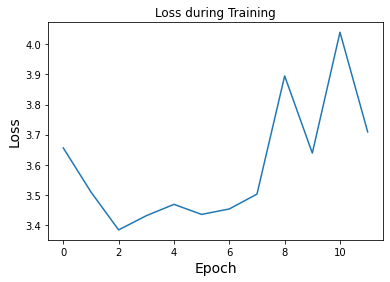

In [0]:
print(val_losses)
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
# print(np.arange(len(val_loss)))
# print(np.array(val_loss))
ax.plot(np.arange(len(val_losses)), np.array(val_losses))
# set x-axis label
ax.set_xlabel("Epoch",fontsize=14)
# set y-axis label
ax.set_ylabel("Loss",fontsize=14)
ax.set_title("Loss during Training")
plt.show()

#Rereate History using JSON

In [0]:
import json

reg_history = json.load(open('/content/drive/My Drive/ECE 542 Final Project/History/history.json'))
aug_history = json.load(open('/content/drive/My Drive/ECE 542 Final Project/History/history_aug.json'))

print(other_history)

NameError: ignored

#Resize Images to Image Min/Max Dims

In [0]:
import cv2
from google.colab.patches import cv2_imshow

root, dirs, file_names = next(os.walk('/content/drive/My Drive/ECE 542 Final Project/RoadImages/Charlotte'))

print(file_names)

for file_name in file_names:

  img = cv2.imread(os.path.join('/content/drive/My Drive/ECE 542 Final Project/RoadImages/Charlotte(0032)', file_name), cv2.IMREAD_UNCHANGED)
  
  print('Original Dimensions : ',img.shape)
  
  scale_percent = 512/img.shape[0]
  print(scale_percent)
  width = int(img.shape[1] * scale_percent)
  height = int(img.shape[0] * scale_percent)
  dim = (width, height)
  # resize image
  resized = cv2.resize(img, dim, interpolation = cv2.INTER_CUBIC) 

  print(int(resized.shape[1]/2)-256)
  #begin_x = random.randint(50, img.shape[1] - 512 - 50)
  rand1 = resized[:, int(resized.shape[1]/2)-366:int(resized.shape[1]/2)+146]
  print(rand1.shape)
  cv2_imshow(rand1)
  
  cv2.imwrite(os.path.join('/content/drive/My Drive/ECE 542 Final Project/RoadImages/Raleigh (Experimental)', "TEST-1" + file_name),rand1)
  #cv2.imwrite(os.path.join('/content/drive/My Drive/ECE 542 Final Project/RoadImages/Raleigh (Experimental)', "TEST-1" + file_name),rand2)